In [1]:
import torch
import tensorflow
from tensorflow.python.client import device_lib
def print_info():
    print('  Versión de TensorFlow: {}'.format(tensorflow.__version__))
    print('  GPU: {}'.format([x.physical_device_desc for x in device_lib.list_local_devices() if x.device_type == 'GPU']))
    print('  Versión Cuda  -> {}'.format(tensorflow.sysconfig.get_build_info()['cuda_version']))
    print('  Versión Cudnn -> {}\n'.format(tensorflow.sysconfig.get_build_info()['cudnn_version']))

print_info()

  Versión de TensorFlow: 2.9.0
  GPU: ['device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5']
  Versión Cuda  -> 64_112
  Versión Cudnn -> 64_8



In [2]:
#Import from library
#Import from library
from datetime import date, time, datetime
import numpy as np
import cv2
from skimage.measure import label, regionprops, regionprops_table
from os import makedirs
#Importar libreriasfrom numpy import expand_dims
from numpy import mean
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from keras import backend
from numpy.random import randn
from numpy.random import randint
from keras.models import Sequential
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
#from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
# example of loading the mnist dataset
from keras.datasets.mnist import load_data
# load saved models
from keras.models import load_model

In [3]:
## Creacion de Dataset
data_img=[]
for num in range(1,5201):
    num_img = str(num).rjust(5,'0')
    dir_img = 'Imagenes\data_all\{}.png'.format(num_img)
    #dir_img = 'Imagenes\dataset_dis\{}.png'.format(num_img)
    temp_img= cv2.imread(dir_img, cv2.IMREAD_GRAYSCALE)
    #th, im_th = cv2.threshold(temp_img, 128, 255, cv2.THRESH_BINARY)
    #plt.imshow(temp_img)
    resize = cv2.resize(temp_img,(28,28),interpolation = cv2.INTER_CUBIC)
    data_img.append(resize)
data_img = np.asarray(data_img)
#data_img = data_img.reshape(5200,28,28,1)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


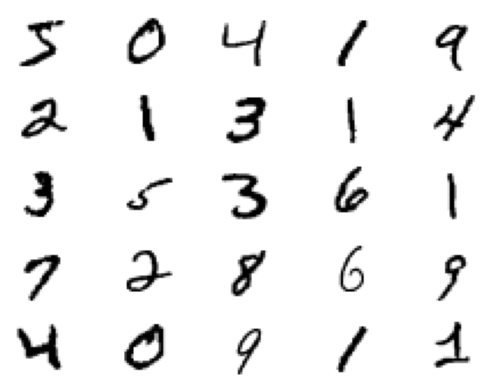

In [4]:
# Abrir archivo de texto para guardar resultados
#datos= open("datos2D.txt",'wt')
#load the images into memory
(trainX,trainy), (testX,testy) =load_data()
# plot images from the training dataset
for i in range(25):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(trainX[i], cmap='gray_r')
#filename = 'base_plot_2DGAN{}.png'.format(str(date.today()))
#plt.savefig(filename)
#plt.close()
#summarize the shape of the dataset
print('Train',trainX.shape, trainy.shape)
print('Test',testX.shape, testy.shape)

(5200, 28, 28)


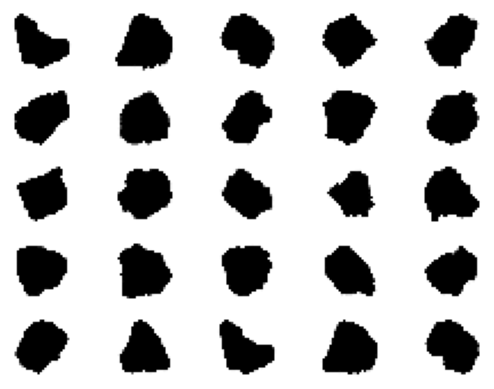

In [5]:
# plot images from the training dataset
for i in range(25):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(data_img[i], cmap='gray_r')
#filename = 'base_plot_2DGAN{}.png'.format(str(date.today()))
#plt.savefig(filename)
#plt.close()
#summarize the shape of the dataset
print(data_img.shape)


In [6]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
# set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value
# clip model weights to hypercube
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)
# get the config
    def get_config(self):
        return {'clip_value': self.clip_value}


In [7]:
# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

In [8]:
# define the standalone critic model
def define_critic(in_shape=(28,28,1)):
    # weight initialization
    init = RandomNormal(stddev=0.2)
    # weight constraint
    const = ClipConstraint(0.01)
    # define model
    model = Sequential()
    #downsample to 14x14
    model.add(Conv2D(64,
                     (4,4),
                     strides=(2,2),
                     padding='same',
                     kernel_initializer = init,
                     kernel_constraint = const,
                     input_shape=in_shape))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    #downsample to 7x7
    model.add(Conv2D(64,
                     (4,4),
                     strides=(2,2),
                     padding='same',
                     kernel_initializer = init,
                     kernel_constraint = const))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    #scoring,linear activation
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    
    model.summary()
    #compile model
    opt = RMSprop(learning_rate=0.0005)
    model.compile(optimizer=opt,
                  loss=wasserstein_loss)
    return model

In [9]:

#define the standalone generator model
def define_generator(latent_dim):
    # weight initialization
    #init = RandomNormal(stddev=0.02)
    #define model
    model = Sequential()
    #foundation for 7x7 image
    n_nodes =128 *7*7 #features maps*dimensions
    model.add(Dense(n_nodes,
                    #kernel_initializer = init,
                    input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128,
                              (4,4),
                              strides=(2,2),
                              #kernel_initializer = init,
                              padding='same'
                             ))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128,
                              (4,4),
                              strides=(2,2),
                              #kernel_initializer = init,
                              padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    #output 28x28x1
    model.add(Conv2D(1,
                     (7,7),
                     activation='tanh',
                     #kernel_initializer = init,
                     padding='same'))
    model.summary()
    return model


In [10]:

#define the combined generator and dicriminatro model,
#for updating the generator
def define_gan(generator,critic):
    #make weights in the discriminator not trainable
    critic.trainable = False
    #connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    #add the discriminator
    model.add(critic)
    model.summary()
    #compile model
    opt = RMSprop(learning_rate=0.00005)
    model.compile(optimizer=opt,
                  loss=wasserstein_loss)
    return model


In [11]:

## load and prepare mnist training images
def load_real_samples():
    # load mnist dataset
    #(trainX, _), (_, _) = data_img
    (trainX, trainy), (_, _) = load_data()
    # select all of the examples for a given class
    selected_ix = trainy == 7
    X = trainX[selected_ix]
    # expand to 3d, e.g. add channels dimension
    #X = expand_dims(trainX, axis=-1)
    X = expand_dims(X, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1 ,1]
    #X = X / 255.0 #[0 ,1]
    X = (X-127.5) / 127.5
    return X


In [12]:

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate class labels, -1 for ✬real✬
    y = -ones((n_samples, 1))
    return X, y


In [13]:

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


In [14]:

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create class labels with 1.0 for ✬fake
    y = ones((n_samples, 1))
    return X, y

In [15]:

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n,n, 1+i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0],
                   cmap='gray_r')
    # save plot to file
    filename = 'results/WGAN/generated_2WGAN_plot_e%04d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()


In [16]:

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    x_fake = (X + 1) / 2.0
    save_plot(x_fake, epoch)
    # save the generator model tile file
    #filename = 'generator_2D_model_%03d.h5' % (epoch + 1)
    #g_model.save(filename)



In [17]:
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
    # plot history
    plt.plot(d1_hist, label='crit_real')
    plt.plot(d2_hist, label='crit_fake')
    plt.plot(g_hist, label='gen')
    plt.legend()
    plt.savefig('results/WGAN/plot_line_plot_loss.png')
    plt.close()

In [18]:

# train the generator and discriminator
def train(g_model, c_model, gan_model, dataset, latent_dim,
          n_epochs=50, n_batch=64,n_critic=5):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # lists for keeping track of loss
    c1_hist, c2_hist, g_hist = list(), list(), list()
    # manually enumerate epochs
    for i in range(n_steps):
        # update the critic more than the generator
        c1_tmp, c2_tmp = list(), list()
        # enumerate batches over the training set
        for _ in range(n_critic):
            # get randomly selected ✬real✬ samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate ✬fake✬ examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
           # update critic model weights
            c_loss1 = c_model.train_on_batch(X_real, y_real)
            #print(c_loss1)
            c1_tmp.append(c_loss1)
            # update critic model weights
            c_loss2 = c_model.train_on_batch(X_fake, y_fake)
            #print(c_loss2)
            c2_tmp.append(c_loss2)
        # store critic loss
        c1_hist.append(mean(c1_tmp))
        c2_hist.append(mean(c2_tmp))
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = -ones((n_batch, 1))
        # update the generator via the critic✬s error
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        #print(g_loss)
        g_hist.append(g_loss)
        # evaluate the model performance every ✬epoch✬
        print('>%d, c1=%.3f, c2=%.3f, g=%.3f' % (i+1,  c1_hist[-1], c2_hist[-1], g_loss))
    
        # evaluate the model performance, sometimes
        if (i+1) % bat_per_epo == 0:
            summarize_performance(i, g_model, latent_dim)
    #line plots of loss
    plot_history(c1_hist, c2_hist, g_hist)

In [19]:
#Make folder in dir
makedirs('results/WGAN', exist_ok=True)
# size of the latent space
latent_dim = 50
# create the discriminator
critic = define_critic()
# create the
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, critic)
# load image data
#dataset = data_img
dataset = load_real_samples()

# train model
train(g_model, critic, gan_model, dataset, latent_dim)#,n_epochs=20)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1088      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          65600     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 1)                 3137      
                                                                 
Total params: 69,825
Trainable params: 69,825
Non-traina

>16, c1=-45.069, c2=22.412, g=-19.428
1/1 [==============================] - 0s 16ms/step
>17, c1=-46.478, c2=25.592, g=-22.047
1/1 [==============================] - 0s 16ms/step
>18, c1=-48.087, c2=27.975, g=-24.759
1/1 [==============================] - 0s 16ms/step
>19, c1=-48.679, c2=30.818, g=-26.627
1/1 [==============================] - 0s 31ms/step
>20, c1=-49.712, c2=33.371, g=-28.240
1/1 [==============================] - 0s 16ms/step
>21, c1=-49.975, c2=35.561, g=-30.873
1/1 [==============================] - 0s 16ms/step
>22, c1=-50.553, c2=37.533, g=-32.381
1/1 [==============================] - 0s 16ms/step
>23, c1=-50.739, c2=38.805, g=-33.246
1/1 [==============================] - 0s 16ms/step
>24, c1=-50.752, c2=40.034, g=-34.313
1/1 [==============================] - 0s 16ms/step
>25, c1=-50.855, c2=40.982, g=-35.529
1/1 [==============================] - 0s 16ms/step
>26, c1=-51.391, c2=42.190, g=-36.113
1/1 [==============================] - 0s 19ms/step
>27, c1=-5

1/1 [==============================] - 0s 0s/step
>72, c1=-53.678, c2=-23.493, g=26.615
1/1 [==============================] - 0s 16ms/step
>73, c1=-51.320, c2=-25.990, g=29.176
1/1 [==============================] - 0s 16ms/step
>74, c1=-53.549, c2=-28.652, g=31.833
1/1 [==============================] - 0s 16ms/step
>75, c1=-51.859, c2=-31.088, g=34.369
1/1 [==============================] - 0s 16ms/step
>76, c1=-53.613, c2=-33.790, g=37.070
1/1 [==============================] - 0s 16ms/step
>77, c1=-51.813, c2=-36.140, g=39.710
1/1 [==============================] - 0s 16ms/step
>78, c1=-49.401, c2=-38.620, g=42.054
1/1 [==============================] - 0s 16ms/step
>79, c1=-52.772, c2=-41.047, g=44.676
1/1 [==============================] - 0s 23ms/step
>80, c1=-49.816, c2=-43.460, g=47.218
1/1 [==============================] - 0s 0s/step
>81, c1=-51.326, c2=-45.813, g=49.708
1/1 [==============================] - 0s 9ms/step
>82, c1=-49.648, c2=-48.125, g=52.150
1/1 [==========

1/1 [==============================] - 0s 16ms/step
>126, c1=-35.456, c2=-142.214, g=153.979
1/1 [==============================] - 0s 16ms/step
>127, c1=-33.066, c2=-143.957, g=156.099
1/1 [==============================] - 0s 14ms/step
>128, c1=-33.213, c2=-146.002, g=158.324
1/1 [==============================] - 0s 16ms/step
>129, c1=-33.510, c2=-148.237, g=160.599
1/1 [==============================] - 0s 8ms/step
>130, c1=-23.065, c2=-149.258, g=162.619
1/1 [==============================] - 0s 16ms/step
>131, c1=-27.620, c2=-151.730, g=164.677
1/1 [==============================] - 0s 16ms/step
>132, c1=-29.702, c2=-153.571, g=166.704
1/1 [==============================] - 0s 16ms/step
>133, c1=-38.749, c2=-156.227, g=169.153
1/1 [==============================] - 0s 16ms/step
>134, c1=-29.276, c2=-157.638, g=171.293
1/1 [==============================] - 0s 16ms/step
>135, c1=-30.534, c2=-159.693, g=173.461
1/1 [==============================] - 0s 16ms/step
>136, c1=-34.841, c

1/1 [==============================] - 0s 16ms/step
>181, c1=-21.974, c2=-247.802, g=270.526
1/1 [==============================] - 0s 0s/step
>182, c1=-29.978, c2=-250.763, g=272.849
1/1 [==============================] - 0s 16ms/step
>183, c1=-17.734, c2=-251.604, g=274.787
1/1 [==============================] - 0s 16ms/step
>184, c1=-28.924, c2=-254.221, g=276.889
1/1 [==============================] - 0s 13ms/step
>185, c1=-24.008, c2=-255.696, g=278.993
1/1 [==============================] - 0s 16ms/step
>186, c1=-32.808, c2=-258.207, g=281.236
1/1 [==============================] - 0s 32ms/step
>187, c1=-24.827, c2=-259.791, g=283.375
1/1 [==============================] - 0s 16ms/step
>188, c1=-13.346, c2=-261.044, g=285.318
1/1 [==============================] - 0s 16ms/step
>189, c1=-22.253, c2=-263.321, g=287.206
1/1 [==============================] - 0s 29ms/step
>190, c1=-11.480, c2=-263.951, g=289.216
1/1 [==============================] - 0s 16ms/step
>191, c1=-27.649, c2

1/1 [==============================] - 0s 16ms/step
>235, c1=-10.354, c2=-337.318, g=372.856
1/1 [==============================] - 0s 16ms/step
>236, c1=-14.943, c2=-339.169, g=365.242
1/1 [==============================] - 0s 16ms/step
>237, c1=-40.895, c2=-335.484, g=363.711
1/1 [==============================] - 0s 19ms/step
>238, c1=-16.941, c2=-328.808, g=364.531
1/1 [==============================] - 0s 16ms/step
>239, c1=-18.474, c2=-321.679, g=357.218
1/1 [==============================] - 0s 16ms/step
>240, c1=-7.825, c2=-310.523, g=347.670
1/1 [==============================] - 0s 16ms/step
>241, c1=-11.121, c2=-295.111, g=342.227
1/1 [==============================] - 0s 16ms/step
>242, c1=-10.508, c2=-286.009, g=326.077
1/1 [==============================] - 0s 16ms/step
>243, c1=-3.964, c2=-266.463, g=295.618
1/1 [==============================] - 0s 16ms/step
>244, c1=-8.366, c2=-250.177, g=282.737
1/1 [==============================] - 0s 16ms/step
>245, c1=4.443, c2=-2

1/1 [==============================] - 0s 16ms/step
>262, c1=-17.725, c2=27.894, g=0.878
1/1 [==============================] - 0s 16ms/step
>263, c1=-17.784, c2=28.472, g=-0.593
1/1 [==============================] - 0s 16ms/step
>264, c1=-19.073, c2=28.632, g=2.057
1/1 [==============================] - 0s 0s/step
>265, c1=-20.144, c2=27.218, g=1.344
1/1 [==============================] - 0s 0s/step
>266, c1=-24.453, c2=24.085, g=2.170
1/1 [==============================] - 0s 16ms/step
>267, c1=-30.209, c2=18.437, g=4.911
1/1 [==============================] - 0s 16ms/step
>268, c1=-22.066, c2=16.797, g=7.715
1/1 [==============================] - 0s 16ms/step
>269, c1=-30.803, c2=11.941, g=10.179
1/1 [==============================] - 0s 16ms/step
>270, c1=-27.157, c2=8.853, g=14.515
1/1 [==============================] - 0s 19ms/step
>271, c1=-35.998, c2=4.725, g=16.642
1/1 [==============================] - 0s 16ms/step
>272, c1=-31.728, c2=3.781, g=17.881
1/1 [==================

1/1 [==============================] - 0s 16ms/step
>317, c1=-291.602, c2=62.009, g=-53.391
1/1 [==============================] - 0s 16ms/step
>318, c1=-298.536, c2=68.009, g=-59.454
1/1 [==============================] - 0s 16ms/step
>319, c1=-302.598, c2=72.904, g=-67.665
1/1 [==============================] - 0s 0s/step
>320, c1=-309.213, c2=78.625, g=-70.130
1/1 [==============================] - 0s 16ms/step
>321, c1=-306.385, c2=83.417, g=-69.917
1/1 [==============================] - 0s 16ms/step
>322, c1=-311.216, c2=86.890, g=-81.643
1/1 [==============================] - 0s 16ms/step
>323, c1=-322.634, c2=87.337, g=-85.027
1/1 [==============================] - 0s 0s/step
>324, c1=-323.632, c2=94.764, g=-87.504
1/1 [==============================] - 0s 16ms/step
>325, c1=-325.985, c2=98.235, g=-91.148
1/1 [==============================] - 0s 16ms/step
>326, c1=-331.026, c2=101.715, g=-96.284
1/1 [==============================] - 0s 16ms/step
>327, c1=-344.478, c2=103.027, 

1/1 [==============================] - 0s 16ms/step
>372, c1=-429.898, c2=317.092, g=-276.947
1/1 [==============================] - 0s 16ms/step
>373, c1=-438.744, c2=322.288, g=-291.972
1/1 [==============================] - 0s 4ms/step
>374, c1=-431.772, c2=329.865, g=-286.163
1/1 [==============================] - 0s 16ms/step
>375, c1=-429.251, c2=323.618, g=-289.271
1/1 [==============================] - 0s 16ms/step
>376, c1=-440.722, c2=328.178, g=-303.828
1/1 [==============================] - 0s 16ms/step
>377, c1=-440.722, c2=334.759, g=-297.745
1/1 [==============================] - 0s 16ms/step
>378, c1=-442.378, c2=345.124, g=-310.120
1/1 [==============================] - 0s 0s/step
>379, c1=-437.752, c2=343.566, g=-312.822
1/1 [==============================] - 0s 5ms/step
>380, c1=-445.562, c2=349.069, g=-309.645
1/1 [==============================] - 0s 16ms/step
>381, c1=-450.209, c2=352.187, g=-312.000
1/1 [==============================] - 0s 16ms/step
>382, c1=-43

1/1 [==============================] - 0s 16ms/step
>426, c1=-383.146, c2=370.256, g=-327.788
1/1 [==============================] - 0s 16ms/step
>427, c1=-373.855, c2=371.957, g=-320.397
1/1 [==============================] - 0s 16ms/step
>428, c1=-373.356, c2=367.920, g=-317.374
1/1 [==============================] - 0s 22ms/step
>429, c1=-375.628, c2=367.874, g=-312.395
1/1 [==============================] - 0s 16ms/step
>430, c1=-369.751, c2=362.518, g=-318.284
1/1 [==============================] - 0s 16ms/step
>431, c1=-362.597, c2=363.122, g=-313.590
1/1 [==============================] - 0s 16ms/step
>432, c1=-360.005, c2=358.778, g=-312.528
1/1 [==============================] - 0s 16ms/step
>433, c1=-360.408, c2=358.778, g=-311.285
1/1 [==============================] - 0s 16ms/step
>434, c1=-353.821, c2=350.394, g=-305.693
1/1 [==============================] - 0s 15ms/step
>435, c1=-351.470, c2=351.294, g=-306.182
1/1 [==============================] - 0s 16ms/step
>436, c1

1/1 [==============================] - 0s 16ms/step
>480, c1=-195.356, c2=206.002, g=-173.627
1/1 [==============================] - 0s 16ms/step
>481, c1=-185.339, c2=198.738, g=-165.556
1/1 [==============================] - 0s 16ms/step
>482, c1=-179.177, c2=190.770, g=-160.425
1/1 [==============================] - 0s 0s/step
>483, c1=-175.298, c2=185.878, g=-156.958
1/1 [==============================] - 0s 20ms/step
>484, c1=-169.434, c2=182.437, g=-151.284
1/1 [==============================] - 0s 16ms/step
>485, c1=-166.153, c2=177.411, g=-148.929
1/1 [==============================] - 0s 16ms/step
>486, c1=-163.715, c2=173.322, g=-142.510
1/1 [==============================] - 0s 16ms/step
>487, c1=-155.846, c2=166.279, g=-138.092
1/1 [==============================] - 0s 0s/step
>488, c1=-151.367, c2=162.506, g=-134.009
1/1 [==============================] - 0s 16ms/step
>489, c1=-145.472, c2=157.149, g=-129.460
1/1 [==============================] - 0s 16ms/step
>490, c1=-14

1/1 [==============================] - 0s 16ms/step
>535, c1=-26.324, c2=28.059, g=-18.930
1/1 [==============================] - 0s 16ms/step
>536, c1=-25.451, c2=26.645, g=-18.736
1/1 [==============================] - 0s 16ms/step
>537, c1=-24.029, c2=26.586, g=-18.298
1/1 [==============================] - 0s 16ms/step
>538, c1=-23.906, c2=25.913, g=-18.500
1/1 [==============================] - 0s 0s/step
>539, c1=-23.470, c2=26.118, g=-19.176
1/1 [==============================] - 0s 16ms/step
>540, c1=-22.823, c2=25.142, g=-18.441
1/1 [==============================] - 0s 16ms/step
>541, c1=-22.984, c2=25.930, g=-18.097
1/1 [==============================] - 0s 6ms/step
>542, c1=-23.155, c2=25.287, g=-18.716
1/1 [==============================] - 0s 16ms/step
>543, c1=-21.688, c2=25.215, g=-18.169
1/1 [==============================] - 0s 16ms/step
>544, c1=-21.571, c2=23.935, g=-18.204
1/1 [==============================] - 0s 16ms/step
>545, c1=-21.055, c2=24.224, g=-17.410
1/

1/1 [==============================] - 0s 16ms/step
>562, c1=-20.156, c2=22.380, g=-18.287
1/1 [==============================] - 0s 16ms/step
>563, c1=-20.212, c2=22.982, g=-18.109
1/1 [==============================] - 0s 16ms/step
>564, c1=-20.151, c2=22.345, g=-17.993
1/1 [==============================] - 0s 16ms/step
>565, c1=-20.066, c2=22.060, g=-17.721
1/1 [==============================] - 0s 16ms/step
>566, c1=-19.579, c2=22.089, g=-18.111
1/1 [==============================] - 0s 16ms/step
>567, c1=-19.930, c2=21.900, g=-17.458
1/1 [==============================] - 0s 16ms/step
>568, c1=-19.218, c2=21.624, g=-17.551
1/1 [==============================] - 0s 0s/step
>569, c1=-19.580, c2=21.876, g=-16.646
1/1 [==============================] - 0s 0s/step
>570, c1=-18.871, c2=21.485, g=-16.910
1/1 [==============================] - 0s 16ms/step
>571, c1=-18.394, c2=20.915, g=-16.939
1/1 [==============================] - 0s 16ms/step
>572, c1=-18.552, c2=20.762, g=-16.996
1/1

1/1 [==============================] - 0s 16ms/step
>617, c1=-16.291, c2=17.877, g=-14.156
1/1 [==============================] - 0s 16ms/step
>618, c1=-15.721, c2=17.368, g=-13.276
1/1 [==============================] - 0s 15ms/step
>619, c1=-15.576, c2=17.194, g=-13.649
1/1 [==============================] - 0s 16ms/step
>620, c1=-15.430, c2=17.244, g=-13.498
1/1 [==============================] - 0s 0s/step
>621, c1=-15.343, c2=17.015, g=-13.192
1/1 [==============================] - 0s 11ms/step
>622, c1=-15.332, c2=16.652, g=-13.087
1/1 [==============================] - 0s 16ms/step
>623, c1=-15.257, c2=16.862, g=-13.124
1/1 [==============================] - 0s 16ms/step
>624, c1=-15.278, c2=16.715, g=-12.861
1/1 [==============================] - 0s 16ms/step
>625, c1=-14.969, c2=16.387, g=-12.800
1/1 [==============================] - 0s 0s/step
>626, c1=-15.068, c2=16.558, g=-12.781
1/1 [==============================] - 0s 16ms/step
>627, c1=-14.923, c2=16.841, g=-12.786
1/1

1/1 [==============================] - 0s 16ms/step
>672, c1=-12.211, c2=13.013, g=-9.752
1/1 [==============================] - 0s 16ms/step
>673, c1=-12.455, c2=12.865, g=-9.119
1/1 [==============================] - 0s 16ms/step
>674, c1=-12.717, c2=13.238, g=-9.657
1/1 [==============================] - 0s 0s/step
>675, c1=-12.360, c2=12.772, g=-8.725
1/1 [==============================] - 0s 16ms/step
>676, c1=-12.381, c2=13.251, g=-9.148
1/1 [==============================] - 0s 0s/step
>677, c1=-12.371, c2=13.287, g=-9.799
1/1 [==============================] - 0s 16ms/step
>678, c1=-12.406, c2=12.833, g=-9.102
1/1 [==============================] - 0s 16ms/step
>679, c1=-12.178, c2=12.787, g=-9.593
1/1 [==============================] - 0s 0s/step
>680, c1=-11.744, c2=12.744, g=-9.190
1/1 [==============================] - 0s 16ms/step
>681, c1=-12.161, c2=12.639, g=-8.926
1/1 [==============================] - 0s 16ms/step
>682, c1=-11.932, c2=12.435, g=-8.874
1/1 [===========

1/1 [==============================] - 0s 16ms/step
>727, c1=-8.806, c2=9.473, g=-5.749
1/1 [==============================] - 0s 16ms/step
>728, c1=-9.000, c2=9.141, g=-6.221
1/1 [==============================] - 0s 16ms/step
>729, c1=-9.237, c2=9.793, g=-6.996
1/1 [==============================] - 0s 16ms/step
>730, c1=-9.418, c2=10.054, g=-6.335
1/1 [==============================] - 0s 14ms/step
>731, c1=-9.244, c2=9.731, g=-6.683
1/1 [==============================] - 0s 16ms/step
>732, c1=-9.187, c2=9.487, g=-6.031
1/1 [==============================] - 0s 16ms/step
>733, c1=-8.666, c2=9.253, g=-5.618
1/1 [==============================] - 0s 16ms/step
>734, c1=-8.928, c2=9.299, g=-6.213
1/1 [==============================] - 0s 16ms/step
>735, c1=-8.831, c2=9.589, g=-6.075
1/1 [==============================] - 0s 16ms/step
>736, c1=-8.692, c2=9.068, g=-6.089
1/1 [==============================] - 0s 16ms/step
>737, c1=-8.547, c2=9.108, g=-5.913
1/1 [==========================

1/1 [==============================] - 0s 16ms/step
>755, c1=-8.119, c2=8.884, g=-5.284
1/1 [==============================] - 0s 32ms/step
>756, c1=-8.304, c2=8.674, g=-6.026
1/1 [==============================] - 0s 16ms/step
>757, c1=-8.587, c2=9.252, g=-5.638
1/1 [==============================] - 0s 16ms/step
>758, c1=-8.453, c2=9.269, g=-6.167
1/1 [==============================] - 0s 16ms/step
>759, c1=-8.573, c2=9.205, g=-5.848
1/1 [==============================] - 0s 17ms/step
>760, c1=-8.208, c2=8.825, g=-5.594
1/1 [==============================] - 0s 16ms/step
>761, c1=-8.242, c2=9.017, g=-6.059
1/1 [==============================] - 0s 28ms/step
>762, c1=-8.481, c2=8.914, g=-6.088
1/1 [==============================] - 0s 16ms/step
>763, c1=-8.549, c2=8.886, g=-5.792
1/1 [==============================] - 0s 16ms/step
>764, c1=-8.192, c2=8.848, g=-5.500
1/1 [==============================] - 0s 16ms/step
>765, c1=-8.103, c2=8.923, g=-5.722
1/1 [===========================

1/1 [==============================] - 0s 16ms/step
>810, c1=-6.020, c2=7.078, g=-4.216
1/1 [==============================] - 0s 16ms/step
>811, c1=-5.830, c2=6.711, g=-3.700
1/1 [==============================] - 0s 16ms/step
>812, c1=-6.114, c2=7.195, g=-4.328
1/1 [==============================] - 0s 16ms/step
>813, c1=-6.183, c2=6.949, g=-4.117
1/1 [==============================] - 0s 16ms/step
>814, c1=-5.853, c2=6.832, g=-4.215
1/1 [==============================] - 0s 16ms/step
>815, c1=-5.588, c2=6.825, g=-4.118
1/1 [==============================] - 0s 16ms/step
>816, c1=-5.434, c2=6.740, g=-3.913
1/1 [==============================] - 0s 16ms/step
>817, c1=-5.744, c2=6.512, g=-3.997
1/1 [==============================] - 0s 16ms/step
>818, c1=-5.694, c2=6.680, g=-3.979
1/1 [==============================] - 0s 16ms/step
>819, c1=-5.445, c2=6.711, g=-3.690
1/1 [==============================] - 0s 16ms/step
>820, c1=-5.823, c2=6.836, g=-3.934
1/1 [===========================

1/1 [==============================] - 0s 16ms/step
>838, c1=-5.367, c2=6.612, g=-3.888
1/1 [==============================] - 0s 16ms/step
>839, c1=-5.421, c2=6.950, g=-4.319
1/1 [==============================] - 0s 16ms/step
>840, c1=-5.715, c2=6.783, g=-3.945
1/1 [==============================] - 0s 0s/step
>841, c1=-5.541, c2=6.448, g=-4.279
1/1 [==============================] - 0s 16ms/step
>842, c1=-5.663, c2=6.986, g=-4.270
1/1 [==============================] - 0s 16ms/step
>843, c1=-5.379, c2=6.562, g=-4.114
1/1 [==============================] - 0s 16ms/step
>844, c1=-5.370, c2=6.879, g=-4.402
1/1 [==============================] - 0s 16ms/step
>845, c1=-5.491, c2=6.648, g=-4.265
1/1 [==============================] - 0s 16ms/step
>846, c1=-5.603, c2=6.942, g=-4.199
1/1 [==============================] - 0s 24ms/step
>847, c1=-5.507, c2=6.828, g=-4.155
1/1 [==============================] - 0s 15ms/step
>848, c1=-5.579, c2=6.897, g=-4.243
1/1 [=============================

1/1 [==============================] - 0s 16ms/step
>893, c1=-4.841, c2=6.432, g=-3.853
1/1 [==============================] - 0s 23ms/step
>894, c1=-4.917, c2=6.074, g=-3.353
1/1 [==============================] - 0s 16ms/step
>895, c1=-4.705, c2=6.256, g=-3.964
1/1 [==============================] - 0s 0s/step
>896, c1=-4.762, c2=6.108, g=-3.651
1/1 [==============================] - 0s 16ms/step
>897, c1=-4.581, c2=6.078, g=-3.965
1/1 [==============================] - 0s 16ms/step
>898, c1=-4.687, c2=6.027, g=-3.964
1/1 [==============================] - 0s 16ms/step
>899, c1=-4.863, c2=6.205, g=-3.938
1/1 [==============================] - 0s 16ms/step
>900, c1=-4.937, c2=6.142, g=-3.793
1/1 [==============================] - 0s 16ms/step
>901, c1=-4.924, c2=6.444, g=-4.092
1/1 [==============================] - 0s 16ms/step
>902, c1=-4.973, c2=6.040, g=-3.992
1/1 [==============================] - 0s 16ms/step
>903, c1=-4.951, c2=6.516, g=-4.209
1/1 [=============================

1/1 [==============================] - 0s 16ms/step
>921, c1=-4.710, c2=6.121, g=-4.082
1/1 [==============================] - 0s 31ms/step
>922, c1=-4.811, c2=6.383, g=-3.914
1/1 [==============================] - 0s 16ms/step
>923, c1=-4.880, c2=6.109, g=-3.990
1/1 [==============================] - 0s 16ms/step
>924, c1=-4.639, c2=6.063, g=-3.451
1/1 [==============================] - 0s 23ms/step
>925, c1=-4.630, c2=6.193, g=-4.000
1/1 [==============================] - 0s 1ms/step
>926, c1=-4.853, c2=6.005, g=-4.039
1/1 [==============================] - 0s 16ms/step
>927, c1=-4.933, c2=6.400, g=-4.203
1/1 [==============================] - 0s 16ms/step
>928, c1=-4.800, c2=6.113, g=-3.764
1/1 [==============================] - 0s 16ms/step
>929, c1=-4.715, c2=5.874, g=-3.781
1/1 [==============================] - 0s 16ms/step
>930, c1=-4.599, c2=6.095, g=-3.703
1/1 [==============================] - 0s 16ms/step
>931, c1=-4.436, c2=5.600, g=-3.428
1/1 [============================

1/1 [==============================] - 0s 16ms/step
>976, c1=-3.750, c2=5.222, g=-2.644
1/1 [==============================] - 0s 16ms/step
>977, c1=-3.738, c2=4.937, g=-3.130
1/1 [==============================] - 0s 16ms/step
>978, c1=-3.895, c2=5.080, g=-2.940
1/1 [==============================] - 0s 16ms/step
>979, c1=-3.872, c2=5.223, g=-3.062
1/1 [==============================] - 0s 16ms/step
>980, c1=-3.795, c2=4.756, g=-3.037
1/1 [==============================] - 0s 16ms/step
>981, c1=-3.904, c2=5.416, g=-3.094
1/1 [==============================] - 0s 16ms/step
>982, c1=-3.777, c2=4.904, g=-2.837
1/1 [==============================] - 0s 16ms/step
>983, c1=-3.750, c2=5.088, g=-2.951
1/1 [==============================] - 0s 16ms/step
>984, c1=-3.709, c2=4.929, g=-2.689
1/1 [==============================] - 0s 25ms/step
>985, c1=-3.652, c2=4.988, g=-2.842
1/1 [==============================] - 0s 14ms/step
>986, c1=-3.618, c2=5.052, g=-2.683
1/1 [===========================

1/1 [==============================] - 0s 16ms/step
>1004, c1=-3.339, c2=4.703, g=-2.590
1/1 [==============================] - 0s 31ms/step
>1005, c1=-2.984, c2=4.392, g=-2.458
1/1 [==============================] - 0s 16ms/step
>1006, c1=-3.336, c2=4.633, g=-2.587
1/1 [==============================] - 0s 16ms/step
>1007, c1=-3.202, c2=4.570, g=-2.525
1/1 [==============================] - 0s 16ms/step
>1008, c1=-3.284, c2=4.194, g=-2.434
1/1 [==============================] - 0s 16ms/step
>1009, c1=-3.124, c2=4.571, g=-2.412
1/1 [==============================] - 0s 28ms/step
>1010, c1=-3.177, c2=4.263, g=-2.273
1/1 [==============================] - 0s 11ms/step
>1011, c1=-2.803, c2=4.150, g=-1.971
1/1 [==============================] - 0s 16ms/step
>1012, c1=-2.715, c2=4.086, g=-2.293
1/1 [==============================] - 0s 16ms/step
>1013, c1=-3.006, c2=4.609, g=-2.362
1/1 [==============================] - 0s 16ms/step
>1014, c1=-3.106, c2=4.217, g=-2.432
1/1 [================

1/1 [==============================] - 0s 16ms/step
>1059, c1=-1.981, c2=3.510, g=-1.587
1/1 [==============================] - 0s 0s/step
>1060, c1=-2.163, c2=3.230, g=-1.202
1/1 [==============================] - 0s 16ms/step
>1061, c1=-2.090, c2=3.485, g=-1.525
1/1 [==============================] - 0s 16ms/step
>1062, c1=-2.163, c2=3.488, g=-1.586
1/1 [==============================] - 0s 16ms/step
>1063, c1=-2.215, c2=3.212, g=-1.650
1/1 [==============================] - 0s 16ms/step
>1064, c1=-2.025, c2=3.293, g=-1.346
1/1 [==============================] - 0s 16ms/step
>1065, c1=-2.299, c2=3.479, g=-1.617
1/1 [==============================] - 0s 16ms/step
>1066, c1=-2.207, c2=3.485, g=-1.741
1/1 [==============================] - 0s 0s/step
>1067, c1=-2.288, c2=3.674, g=-1.639
1/1 [==============================] - 0s 15ms/step
>1068, c1=-2.212, c2=3.459, g=-1.743
1/1 [==============================] - 0s 16ms/step
>1069, c1=-2.135, c2=3.394, g=-1.256
1/1 [====================

1/1 [==============================] - 0s 16ms/step
>1114, c1=-1.413, c2=2.538, g=-0.861
1/1 [==============================] - 0s 16ms/step
>1115, c1=-1.622, c2=2.893, g=-0.996
1/1 [==============================] - 0s 0s/step
>1116, c1=-1.642, c2=2.795, g=-0.979
1/1 [==============================] - 0s 31ms/step
>1117, c1=-1.624, c2=2.820, g=-1.062
1/1 [==============================] - 0s 16ms/step
>1118, c1=-1.358, c2=2.785, g=-0.994
1/1 [==============================] - 0s 16ms/step
>1119, c1=-1.324, c2=2.604, g=-0.680
1/1 [==============================] - 0s 11ms/step
>1120, c1=-1.418, c2=2.610, g=-0.571
1/1 [==============================] - 0s 16ms/step
>1121, c1=-1.462, c2=2.622, g=-0.967
1/1 [==============================] - 0s 16ms/step
>1122, c1=-1.435, c2=2.723, g=-0.986
1/1 [==============================] - 0s 16ms/step
>1123, c1=-1.509, c2=2.626, g=-1.068
1/1 [==============================] - 0s 24ms/step
>1124, c1=-1.593, c2=3.041, g=-1.363
1/1 [==================

1/1 [==============================] - 0s 16ms/step
>1169, c1=-0.694, c2=2.012, g=-0.127
1/1 [==============================] - 0s 16ms/step
>1170, c1=-0.526, c2=1.888, g=0.236
1/1 [==============================] - 0s 18ms/step
>1171, c1=-0.772, c2=1.654, g=0.162
1/1 [==============================] - 0s 16ms/step
>1172, c1=-0.801, c2=2.080, g=-0.386
1/1 [==============================] - 0s 16ms/step
>1173, c1=-0.525, c2=1.807, g=-0.142
1/1 [==============================] - 0s 16ms/step
>1174, c1=-0.661, c2=1.611, g=0.012
1/1 [==============================] - 0s 0s/step
>1175, c1=-0.427, c2=1.791, g=0.075
1/1 [==============================] - 0s 9ms/step
>1176, c1=-0.486, c2=1.573, g=0.483
1/1 [==============================] - 0s 16ms/step
>1177, c1=-0.610, c2=1.896, g=-0.469
1/1 [==============================] - 0s 16ms/step
>1178, c1=-0.613, c2=1.710, g=-0.326
1/1 [==============================] - 0s 31ms/step
>1179, c1=-0.828, c2=2.035, g=-0.407
1/1 [========================

1/1 [==============================] - 0s 16ms/step
>1224, c1=0.071, c2=0.895, g=0.336
1/1 [==============================] - 0s 16ms/step
>1225, c1=-0.328, c2=1.485, g=0.355
1/1 [==============================] - 0s 16ms/step
>1226, c1=-0.364, c2=1.569, g=0.072
1/1 [==============================] - 0s 16ms/step
>1227, c1=-0.355, c2=1.474, g=0.290
1/1 [==============================] - 0s 0s/step
>1228, c1=-0.120, c2=1.237, g=0.299
1/1 [==============================] - 0s 31ms/step
>1229, c1=-0.194, c2=1.498, g=0.076
1/1 [==============================] - 0s 16ms/step
>1230, c1=-0.286, c2=1.354, g=0.092
1/1 [==============================] - 0s 16ms/step
>1231, c1=-0.230, c2=1.368, g=0.378
1/1 [==============================] - 0s 16ms/step
>1232, c1=-0.282, c2=1.388, g=0.306
1/1 [==============================] - 0s 16ms/step
>1233, c1=-0.471, c2=1.360, g=0.544
1/1 [==============================] - 0s 32ms/step
>1234, c1=-0.325, c2=1.598, g=0.374
1/1 [==============================

1/1 [==============================] - 0s 16ms/step
>1279, c1=-0.163, c2=1.025, g=0.605
1/1 [==============================] - 0s 15ms/step
>1280, c1=-0.039, c2=1.432, g=0.069
1/1 [==============================] - 0s 16ms/step
>1281, c1=-0.125, c2=1.069, g=0.231
1/1 [==============================] - 0s 16ms/step
>1282, c1=-0.122, c2=1.164, g=0.546
1/1 [==============================] - 0s 16ms/step
>1283, c1=-0.119, c2=1.313, g=0.168
1/1 [==============================] - 0s 12ms/step
>1284, c1=-0.089, c2=1.055, g=0.898
1/1 [==============================] - 0s 16ms/step
>1285, c1=0.137, c2=1.039, g=0.587
1/1 [==============================] - 0s 10ms/step
>1286, c1=-0.124, c2=1.399, g=0.213
1/1 [==============================] - 0s 16ms/step
>1287, c1=-0.015, c2=1.001, g=0.794
1/1 [==============================] - 0s 16ms/step
>1288, c1=0.219, c2=1.088, g=0.410
1/1 [==============================] - 0s 0s/step
>1289, c1=-0.109, c2=1.164, g=0.396
1/1 [==============================]

1/1 [==============================] - 0s 16ms/step
>1335, c1=0.337, c2=0.551, g=1.220
1/1 [==============================] - 0s 16ms/step
>1336, c1=0.717, c2=0.290, g=1.047
1/1 [==============================] - 0s 16ms/step
>1337, c1=0.763, c2=0.458, g=1.303
1/1 [==============================] - 0s 16ms/step
>1338, c1=0.610, c2=0.387, g=0.690
1/1 [==============================] - 0s 16ms/step
>1339, c1=0.224, c2=0.900, g=0.790
1/1 [==============================] - 0s 16ms/step
>1340, c1=0.327, c2=0.844, g=0.644
1/1 [==============================] - 0s 16ms/step
>1341, c1=0.627, c2=0.516, g=0.833
1/1 [==============================] - 0s 16ms/step
>1342, c1=0.435, c2=0.518, g=1.201
1/1 [==============================] - 0s 16ms/step
>1343, c1=0.809, c2=0.489, g=0.712
1/1 [==============================] - 0s 16ms/step
>1344, c1=0.672, c2=0.341, g=1.042
1/1 [==============================] - 0s 16ms/step
>1345, c1=0.557, c2=0.358, g=0.861
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 16ms/step
>1390, c1=0.967, c2=0.217, g=1.145
1/1 [==============================] - 0s 16ms/step
>1391, c1=0.812, c2=0.229, g=1.168
1/1 [==============================] - 0s 23ms/step
>1392, c1=0.807, c2=0.317, g=1.496
1/1 [==============================] - 0s 31ms/step
>1393, c1=0.823, c2=0.372, g=0.916
1/1 [==============================] - 0s 16ms/step
>1394, c1=0.531, c2=0.329, g=1.137
1/1 [==============================] - 0s 16ms/step
>1395, c1=0.977, c2=0.067, g=1.049
1/1 [==============================] - 0s 31ms/step
>1396, c1=0.634, c2=0.316, g=1.214
1/1 [==============================] - 0s 32ms/step
>1397, c1=0.839, c2=0.421, g=0.964
1/1 [==============================] - 0s 7ms/step
>1398, c1=0.782, c2=0.392, g=0.956
1/1 [==============================] - 0s 14ms/step
>1399, c1=0.526, c2=0.406, g=0.793
1/1 [==============================] - 0s 16ms/step
>1400, c1=0.950, c2=0.224, g=1.700
1/1 [==============================] - 0s 16

1/1 [==============================] - 0s 16ms/step
>1418, c1=0.963, c2=0.040, g=2.001
1/1 [==============================] - 0s 0s/step
>1419, c1=1.304, c2=-0.235, g=1.578
1/1 [==============================] - 0s 16ms/step
>1420, c1=1.227, c2=-0.094, g=1.719
1/1 [==============================] - 0s 16ms/step
>1421, c1=1.463, c2=-0.351, g=1.421
1/1 [==============================] - 0s 16ms/step
>1422, c1=1.157, c2=-0.286, g=1.945
1/1 [==============================] - 0s 16ms/step
>1423, c1=1.396, c2=-0.256, g=1.506
1/1 [==============================] - 0s 16ms/step
>1424, c1=1.423, c2=-0.247, g=1.756
1/1 [==============================] - 0s 16ms/step
>1425, c1=1.376, c2=-0.418, g=1.764
1/1 [==============================] - 0s 18ms/step
>1426, c1=1.197, c2=-0.361, g=1.474
1/1 [==============================] - 0s 16ms/step
>1427, c1=1.574, c2=-0.175, g=1.350
1/1 [==============================] - 0s 16ms/step
>1428, c1=1.059, c2=-0.121, g=1.294
1/1 [==============================

1/1 [==============================] - 0s 25ms/step
>1446, c1=1.440, c2=-0.299, g=2.069
1/1 [==============================] - 0s 0s/step
>1447, c1=1.538, c2=-0.473, g=1.647
1/1 [==============================] - 0s 16ms/step
>1448, c1=1.214, c2=-0.163, g=1.438
1/1 [==============================] - 0s 16ms/step
>1449, c1=1.366, c2=-0.221, g=1.513
1/1 [==============================] - 0s 16ms/step
>1450, c1=1.422, c2=-0.280, g=1.667
1/1 [==============================] - 0s 16ms/step
>1451, c1=1.492, c2=-0.447, g=1.900
1/1 [==============================] - 0s 16ms/step
>1452, c1=1.499, c2=-0.605, g=1.788
1/1 [==============================] - 0s 16ms/step
>1453, c1=1.815, c2=-0.586, g=2.165
1/1 [==============================] - 0s 16ms/step
>1454, c1=1.416, c2=-0.564, g=1.905
1/1 [==============================] - 0s 16ms/step
>1455, c1=1.895, c2=-0.649, g=1.627
1/1 [==============================] - 0s 0s/step
>1456, c1=1.348, c2=-0.541, g=1.852
1/1 [==============================]

1/1 [==============================] - 0s 16ms/step
>1501, c1=1.739, c2=-0.791, g=1.802
1/1 [==============================] - 0s 16ms/step
>1502, c1=1.406, c2=-0.231, g=1.714
1/1 [==============================] - 0s 16ms/step
>1503, c1=1.382, c2=-0.463, g=1.935
1/1 [==============================] - 0s 16ms/step
>1504, c1=1.734, c2=-0.584, g=2.239
1/1 [==============================] - 0s 0s/step
>1505, c1=1.864, c2=-0.914, g=1.794
1/1 [==============================] - 0s 16ms/step
>1506, c1=1.450, c2=-0.298, g=1.956
1/1 [==============================] - 0s 16ms/step
>1507, c1=1.580, c2=-0.654, g=1.522
1/1 [==============================] - 0s 16ms/step
>1508, c1=1.410, c2=-0.345, g=1.728
1/1 [==============================] - 0s 17ms/step
>1509, c1=1.565, c2=-0.532, g=2.075
1/1 [==============================] - 0s 16ms/step
>1510, c1=1.868, c2=-0.767, g=2.171
1/1 [==============================] - 0s 16ms/step
>1511, c1=2.110, c2=-0.999, g=1.981
1/1 [=============================

1/1 [==============================] - 0s 16ms/step
>1556, c1=2.446, c2=-1.469, g=2.581
1/1 [==============================] - 0s 16ms/step
>1557, c1=2.689, c2=-1.656, g=2.650
1/1 [==============================] - 0s 16ms/step
>1558, c1=2.433, c2=-1.218, g=2.469
1/1 [==============================] - 0s 16ms/step
>1559, c1=2.217, c2=-1.344, g=2.560
1/1 [==============================] - 0s 17ms/step
>1560, c1=2.221, c2=-1.232, g=2.366
1/1 [==============================] - 0s 16ms/step
>1561, c1=2.524, c2=-1.508, g=2.949
1/1 [==============================] - 0s 16ms/step
>1562, c1=2.513, c2=-1.583, g=3.077
1/1 [==============================] - 0s 21ms/step
>1563, c1=2.595, c2=-1.453, g=2.859
1/1 [==============================] - 0s 16ms/step
>1564, c1=2.691, c2=-1.567, g=2.670
1/1 [==============================] - 0s 16ms/step
>1565, c1=2.275, c2=-1.401, g=2.464
1/1 [==============================] - 0s 16ms/step
>1566, c1=2.283, c2=-1.156, g=2.506
1/1 [===========================

1/1 [==============================] - 0s 16ms/step
>1612, c1=2.632, c2=-1.535, g=2.833
1/1 [==============================] - 0s 0s/step
>1613, c1=2.534, c2=-1.425, g=2.787
1/1 [==============================] - 0s 19ms/step
>1614, c1=2.506, c2=-1.722, g=2.838
1/1 [==============================] - 0s 16ms/step
>1615, c1=2.846, c2=-1.777, g=2.855
1/1 [==============================] - 0s 16ms/step
>1616, c1=3.010, c2=-1.828, g=3.749
1/1 [==============================] - 0s 16ms/step
>1617, c1=2.909, c2=-1.936, g=3.009
1/1 [==============================] - 0s 16ms/step
>1618, c1=2.952, c2=-1.845, g=2.715
1/1 [==============================] - 0s 6ms/step
>1619, c1=2.661, c2=-1.762, g=2.963
1/1 [==============================] - 0s 16ms/step
>1620, c1=2.987, c2=-1.892, g=2.951
1/1 [==============================] - 0s 16ms/step
>1621, c1=2.455, c2=-1.779, g=2.770
1/1 [==============================] - 0s 16ms/step
>1622, c1=2.969, c2=-1.745, g=2.751
1/1 [==============================

1/1 [==============================] - 0s 16ms/step
>1667, c1=3.571, c2=-2.443, g=3.803
1/1 [==============================] - 0s 31ms/step
>1668, c1=3.523, c2=-2.492, g=3.442
1/1 [==============================] - 0s 15ms/step
>1669, c1=3.468, c2=-2.494, g=4.173
1/1 [==============================] - 0s 0s/step
>1670, c1=3.399, c2=-2.568, g=3.325
1/1 [==============================] - 0s 16ms/step
>1671, c1=3.692, c2=-2.577, g=3.460
1/1 [==============================] - 0s 16ms/step
>1672, c1=3.469, c2=-2.527, g=4.292
1/1 [==============================] - 0s 16ms/step
>1673, c1=3.306, c2=-2.474, g=3.328
1/1 [==============================] - 0s 16ms/step
>1674, c1=3.241, c2=-2.196, g=3.472
1/1 [==============================] - 0s 0s/step
>1675, c1=3.293, c2=-2.385, g=3.429
1/1 [==============================] - 0s 16ms/step
>1676, c1=3.490, c2=-2.408, g=3.678
1/1 [==============================] - 0s 16ms/step
>1677, c1=3.298, c2=-2.369, g=4.499
1/1 [==============================]

1/1 [==============================] - 0s 16ms/step
>1695, c1=3.403, c2=-2.435, g=3.873
1/1 [==============================] - 0s 16ms/step
>1696, c1=3.821, c2=-2.704, g=3.931
1/1 [==============================] - 0s 16ms/step
>1697, c1=3.589, c2=-2.779, g=4.027
1/1 [==============================] - 0s 16ms/step
>1698, c1=3.903, c2=-2.840, g=3.945
1/1 [==============================] - 0s 11ms/step
>1699, c1=3.705, c2=-2.718, g=3.666
1/1 [==============================] - 0s 16ms/step
>1700, c1=3.860, c2=-2.836, g=4.093
1/1 [==============================] - 0s 0s/step
>1701, c1=3.714, c2=-2.789, g=3.659
1/1 [==============================] - 0s 16ms/step
>1702, c1=3.719, c2=-2.695, g=4.093
1/1 [==============================] - 0s 19ms/step
>1703, c1=3.635, c2=-2.767, g=3.561
1/1 [==============================] - 0s 16ms/step
>1704, c1=3.760, c2=-2.552, g=3.531
1/1 [==============================] - 0s 16ms/step
>1705, c1=3.411, c2=-2.606, g=3.391
1/1 [=============================

1/1 [==============================] - 0s 16ms/step
>1750, c1=3.810, c2=-2.907, g=3.726
1/1 [==============================] - 0s 16ms/step
>1751, c1=3.740, c2=-2.691, g=3.778
1/1 [==============================] - 0s 16ms/step
>1752, c1=3.843, c2=-2.910, g=3.832
1/1 [==============================] - 0s 16ms/step
>1753, c1=3.522, c2=-2.713, g=4.338
1/1 [==============================] - 0s 16ms/step
>1754, c1=4.044, c2=-3.010, g=3.803
1/1 [==============================] - 0s 16ms/step
>1755, c1=4.106, c2=-3.087, g=4.179
1/1 [==============================] - 0s 16ms/step
>1756, c1=3.965, c2=-3.144, g=4.907
1/1 [==============================] - 0s 16ms/step
>1757, c1=4.218, c2=-3.049, g=3.982
1/1 [==============================] - 0s 21ms/step
>1758, c1=4.061, c2=-3.017, g=3.882
1/1 [==============================] - 0s 16ms/step
>1759, c1=3.939, c2=-3.042, g=4.136
1/1 [==============================] - 0s 16ms/step
>1760, c1=4.048, c2=-3.198, g=3.914
1/1 [===========================

1/1 [==============================] - 0s 25ms/step
>1778, c1=4.130, c2=-3.592, g=5.305
1/1 [==============================] - 0s 16ms/step
>1779, c1=4.672, c2=-3.609, g=4.324
1/1 [==============================] - 0s 16ms/step
>1780, c1=4.321, c2=-3.526, g=4.804
1/1 [==============================] - 0s 16ms/step
>1781, c1=4.402, c2=-3.487, g=4.362
1/1 [==============================] - 0s 16ms/step
>1782, c1=4.599, c2=-3.446, g=4.191
1/1 [==============================] - 0s 16ms/step
>1783, c1=4.044, c2=-3.241, g=4.505
1/1 [==============================] - 0s 0s/step
>1784, c1=4.356, c2=-3.377, g=4.303
1/1 [==============================] - 0s 16ms/step
>1785, c1=4.378, c2=-3.386, g=4.652
1/1 [==============================] - 0s 16ms/step
>1786, c1=4.266, c2=-3.277, g=4.339
1/1 [==============================] - 0s 16ms/step
>1787, c1=4.373, c2=-3.594, g=4.282
1/1 [==============================] - 0s 16ms/step
>1788, c1=4.473, c2=-3.310, g=5.232
1/1 [=============================

1/1 [==============================] - 0s 16ms/step
>1833, c1=4.397, c2=-3.657, g=4.422
1/1 [==============================] - 0s 20ms/step
>1834, c1=4.283, c2=-3.474, g=5.012
1/1 [==============================] - 0s 16ms/step
>1835, c1=4.548, c2=-3.522, g=4.278
1/1 [==============================] - 0s 16ms/step
>1836, c1=4.432, c2=-3.450, g=5.085
1/1 [==============================] - 0s 16ms/step
>1837, c1=4.455, c2=-3.475, g=4.303
1/1 [==============================] - 0s 16ms/step
>1838, c1=4.671, c2=-3.744, g=4.643
1/1 [==============================] - 0s 16ms/step
>1839, c1=4.220, c2=-3.597, g=4.936
1/1 [==============================] - 0s 0s/step
>1840, c1=4.563, c2=-3.701, g=4.303
1/1 [==============================] - 0s 16ms/step
>1841, c1=4.510, c2=-3.358, g=4.638
1/1 [==============================] - 0s 12ms/step
>1842, c1=4.297, c2=-3.427, g=4.342
1/1 [==============================] - 0s 16ms/step
>1843, c1=4.571, c2=-3.479, g=4.499
1/1 [=============================

1/1 [==============================] - 0s 16ms/step
>1861, c1=4.794, c2=-3.872, g=4.623
1/1 [==============================] - 0s 16ms/step
>1862, c1=4.527, c2=-3.621, g=4.710
1/1 [==============================] - 0s 16ms/step
>1863, c1=4.631, c2=-3.680, g=4.814
1/1 [==============================] - 0s 9ms/step
>1864, c1=4.622, c2=-3.795, g=4.583
1/1 [==============================] - 0s 16ms/step
>1865, c1=4.468, c2=-3.549, g=4.702
1/1 [==============================] - 0s 16ms/step
>1866, c1=4.623, c2=-3.679, g=4.652
1/1 [==============================] - 0s 16ms/step
>1867, c1=4.516, c2=-3.688, g=4.374
1/1 [==============================] - 0s 20ms/step
>1868, c1=4.644, c2=-3.718, g=4.509
1/1 [==============================] - 0s 16ms/step
>1869, c1=4.549, c2=-3.554, g=4.567
1/1 [==============================] - 0s 0s/step
>1870, c1=4.623, c2=-3.792, g=4.505
1/1 [==============================] - 0s 0s/step
>1871, c1=4.763, c2=-3.764, g=4.676
1/1 [==============================] 

1/1 [==============================] - 0s 3ms/step
>1916, c1=4.912, c2=-4.122, g=5.224
1/1 [==============================] - 0s 16ms/step
>1917, c1=5.250, c2=-4.203, g=5.053
1/1 [==============================] - 0s 16ms/step
>1918, c1=4.879, c2=-4.055, g=4.978
1/1 [==============================] - 0s 16ms/step
>1919, c1=4.791, c2=-3.937, g=5.064
1/1 [==============================] - 0s 16ms/step
>1920, c1=4.923, c2=-4.079, g=5.067
1/1 [==============================] - 0s 16ms/step
>1921, c1=5.033, c2=-4.078, g=5.306
1/1 [==============================] - 0s 16ms/step
>1922, c1=4.883, c2=-4.095, g=4.933
1/1 [==============================] - 0s 13ms/step
>1923, c1=4.936, c2=-3.987, g=4.836
1/1 [==============================] - 0s 16ms/step
>1924, c1=4.761, c2=-4.005, g=5.404
1/1 [==============================] - 0s 16ms/step
>1925, c1=4.831, c2=-3.791, g=4.697
1/1 [==============================] - 0s 16ms/step
>1926, c1=4.828, c2=-3.971, g=5.091
1/1 [============================

1/1 [==============================] - 0s 31ms/step
>1971, c1=5.270, c2=-4.389, g=5.104
1/1 [==============================] - 0s 16ms/step
>1972, c1=5.131, c2=-4.304, g=5.477
1/1 [==============================] - 0s 16ms/step
>1973, c1=5.357, c2=-4.409, g=5.213
1/1 [==============================] - 0s 16ms/step
>1974, c1=5.203, c2=-4.377, g=5.629
1/1 [==============================] - 0s 16ms/step
>1975, c1=5.198, c2=-4.323, g=5.473
1/1 [==============================] - 0s 16ms/step
>1976, c1=5.313, c2=-4.589, g=5.672
1/1 [==============================] - 0s 16ms/step
>1977, c1=5.633, c2=-4.571, g=5.339
1/1 [==============================] - 0s 16ms/step
>1978, c1=5.232, c2=-4.506, g=5.287
1/1 [==============================] - 0s 16ms/step
>1979, c1=5.499, c2=-4.407, g=5.295
1/1 [==============================] - 0s 7ms/step
>1980, c1=5.520, c2=-4.588, g=5.306
1/1 [==============================] - 0s 16ms/step
>1981, c1=5.428, c2=-4.663, g=5.405
1/1 [============================

1/1 [==============================] - 0s 17ms/step
>2027, c1=5.411, c2=-4.673, g=6.083
1/1 [==============================] - 0s 0s/step
>2028, c1=5.592, c2=-4.763, g=5.509
1/1 [==============================] - 0s 16ms/step
>2029, c1=5.621, c2=-4.640, g=5.574
1/1 [==============================] - 0s 3ms/step
>2030, c1=5.660, c2=-4.754, g=5.958
1/1 [==============================] - 0s 16ms/step
>2031, c1=5.580, c2=-4.834, g=5.279
1/1 [==============================] - 0s 16ms/step
>2032, c1=5.393, c2=-4.700, g=6.057
1/1 [==============================] - 0s 9ms/step
>2033, c1=5.517, c2=-4.764, g=5.441
1/1 [==============================] - 0s 16ms/step
>2034, c1=5.504, c2=-4.585, g=5.629
1/1 [==============================] - 0s 16ms/step
>2035, c1=5.288, c2=-4.659, g=5.824
1/1 [==============================] - 0s 0s/step
>2036, c1=5.481, c2=-4.649, g=5.601
1/1 [==============================] - 0s 27ms/step
>2037, c1=5.570, c2=-4.606, g=5.472
1/1 [==============================] -

1/1 [==============================] - 0s 16ms/step
>2082, c1=5.778, c2=-4.971, g=5.637
1/1 [==============================] - 0s 16ms/step
>2083, c1=5.893, c2=-4.983, g=5.956
1/1 [==============================] - 0s 16ms/step
>2084, c1=5.747, c2=-4.965, g=5.899
1/1 [==============================] - 0s 2ms/step
>2085, c1=5.785, c2=-4.889, g=5.915
1/1 [==============================] - 0s 16ms/step
>2086, c1=5.585, c2=-4.693, g=5.937
1/1 [==============================] - 0s 16ms/step
>2087, c1=5.878, c2=-4.955, g=6.397
1/1 [==============================] - 0s 13ms/step
>2088, c1=5.832, c2=-5.055, g=5.814
1/1 [==============================] - 0s 16ms/step
>2089, c1=5.802, c2=-5.075, g=5.965
1/1 [==============================] - 0s 16ms/step
>2090, c1=5.909, c2=-4.931, g=5.839
1/1 [==============================] - 0s 16ms/step
>2091, c1=5.958, c2=-5.012, g=5.754
1/1 [==============================] - 0s 16ms/step
>2092, c1=5.776, c2=-5.101, g=6.377
1/1 [============================

1/1 [==============================] - 0s 16ms/step
>2110, c1=5.696, c2=-4.830, g=6.027
1/1 [==============================] - 0s 16ms/step
>2111, c1=5.908, c2=-5.006, g=5.666
1/1 [==============================] - 0s 16ms/step
>2112, c1=5.959, c2=-4.984, g=5.693
1/1 [==============================] - 0s 0s/step
>2113, c1=5.837, c2=-5.124, g=6.508
1/1 [==============================] - 0s 0s/step
>2114, c1=6.008, c2=-5.204, g=6.123
1/1 [==============================] - 0s 16ms/step
>2115, c1=6.053, c2=-5.086, g=6.327
1/1 [==============================] - 0s 24ms/step
>2116, c1=5.963, c2=-5.183, g=6.366
1/1 [==============================] - 0s 16ms/step
>2117, c1=6.044, c2=-5.306, g=5.823
1/1 [==============================] - 0s 16ms/step
>2118, c1=5.929, c2=-5.152, g=5.959
1/1 [==============================] - 0s 16ms/step
>2119, c1=6.024, c2=-5.034, g=5.948
1/1 [==============================] - 0s 21ms/step
>2120, c1=5.825, c2=-5.012, g=5.817
1/1 [==============================]

1/1 [==============================] - 0s 16ms/step
>2165, c1=6.504, c2=-5.445, g=6.385
1/1 [==============================] - 0s 6ms/step
>2166, c1=6.469, c2=-5.493, g=6.081
1/1 [==============================] - 0s 19ms/step
>2167, c1=6.252, c2=-5.444, g=6.596
1/1 [==============================] - 0s 16ms/step
>2168, c1=6.297, c2=-5.476, g=6.785
1/1 [==============================] - 0s 16ms/step
>2169, c1=6.388, c2=-5.437, g=5.855
1/1 [==============================] - 0s 16ms/step
>2170, c1=6.020, c2=-5.326, g=6.214
1/1 [==============================] - 0s 16ms/step
>2171, c1=6.194, c2=-5.259, g=6.222
1/1 [==============================] - 0s 16ms/step
>2172, c1=6.305, c2=-5.346, g=5.971
1/1 [==============================] - 0s 16ms/step
>2173, c1=6.215, c2=-5.343, g=6.496
1/1 [==============================] - 0s 16ms/step
>2174, c1=6.165, c2=-5.334, g=6.685
1/1 [==============================] - 0s 16ms/step
>2175, c1=6.281, c2=-5.463, g=5.877
1/1 [============================

1/1 [==============================] - 0s 16ms/step
>2193, c1=6.591, c2=-5.619, g=6.075
1/1 [==============================] - 0s 16ms/step
>2194, c1=6.359, c2=-5.504, g=6.551
1/1 [==============================] - 0s 16ms/step
>2195, c1=6.268, c2=-5.482, g=6.194
1/1 [==============================] - 0s 0s/step
>2196, c1=6.213, c2=-5.350, g=6.110
1/1 [==============================] - 0s 14ms/step
>2197, c1=6.440, c2=-5.449, g=6.947
1/1 [==============================] - 0s 16ms/step
>2198, c1=6.435, c2=-5.655, g=6.237
1/1 [==============================] - 0s 16ms/step
>2199, c1=6.160, c2=-5.496, g=6.020
1/1 [==============================] - 0s 16ms/step
>2200, c1=6.106, c2=-5.313, g=6.220
1/1 [==============================] - 0s 16ms/step
>2201, c1=6.525, c2=-5.405, g=6.236
1/1 [==============================] - 0s 31ms/step
>2202, c1=6.262, c2=-5.516, g=6.547
1/1 [==============================] - 0s 16ms/step
>2203, c1=6.421, c2=-5.538, g=6.587
1/1 [=============================

1/1 [==============================] - 0s 9ms/step
>2248, c1=6.680, c2=-5.670, g=6.643
1/1 [==============================] - 0s 16ms/step
>2249, c1=6.502, c2=-5.670, g=6.457
1/1 [==============================] - 0s 20ms/step
>2250, c1=6.457, c2=-5.849, g=6.966
1/1 [==============================] - 0s 16ms/step
>2251, c1=6.522, c2=-5.686, g=6.341
1/1 [==============================] - 0s 16ms/step
>2252, c1=6.450, c2=-5.662, g=6.523
1/1 [==============================] - 0s 8ms/step
>2253, c1=6.296, c2=-5.582, g=6.330
1/1 [==============================] - 0s 16ms/step
>2254, c1=6.351, c2=-5.507, g=6.978
1/1 [==============================] - 0s 16ms/step
>2255, c1=6.524, c2=-5.660, g=6.369
1/1 [==============================] - 0s 16ms/step
>2256, c1=6.374, c2=-5.570, g=6.253
1/1 [==============================] - 0s 16ms/step
>2257, c1=6.584, c2=-5.678, g=6.712
1/1 [==============================] - 0s 16ms/step
>2258, c1=6.466, c2=-5.730, g=6.657
1/1 [=============================

1/1 [==============================] - 0s 16ms/step
>2276, c1=6.445, c2=-5.654, g=6.562
1/1 [==============================] - 0s 0s/step
>2277, c1=6.515, c2=-5.646, g=6.470
1/1 [==============================] - 0s 16ms/step
>2278, c1=6.490, c2=-5.753, g=6.852
1/1 [==============================] - 0s 0s/step
>2279, c1=6.383, c2=-5.740, g=6.421
1/1 [==============================] - 0s 12ms/step
>2280, c1=6.520, c2=-5.786, g=6.958
1/1 [==============================] - 0s 16ms/step
>2281, c1=6.679, c2=-5.816, g=6.807
1/1 [==============================] - 0s 16ms/step
>2282, c1=6.529, c2=-5.716, g=6.460
1/1 [==============================] - 0s 0s/step
>2283, c1=6.371, c2=-5.655, g=6.273
1/1 [==============================] - 0s 18ms/step
>2284, c1=6.448, c2=-5.628, g=6.606
1/1 [==============================] - 0s 16ms/step
>2285, c1=6.636, c2=-5.711, g=6.442
1/1 [==============================] - 0s 0s/step
>2286, c1=6.554, c2=-5.591, g=6.317
1/1 [==============================] - 0

1/1 [==============================] - 0s 21ms/step
>2331, c1=6.610, c2=-5.886, g=7.215
1/1 [==============================] - 0s 16ms/step
>2332, c1=6.837, c2=-5.964, g=6.694
1/1 [==============================] - 0s 16ms/step
>2333, c1=6.633, c2=-6.017, g=7.080
1/1 [==============================] - 0s 16ms/step
>2334, c1=6.785, c2=-5.920, g=6.667
1/1 [==============================] - 0s 16ms/step
>2335, c1=6.678, c2=-6.043, g=6.777
1/1 [==============================] - 0s 5ms/step
>2336, c1=6.867, c2=-6.110, g=6.767
1/1 [==============================] - 0s 16ms/step
>2337, c1=6.664, c2=-6.044, g=6.973
1/1 [==============================] - 0s 16ms/step
>2338, c1=6.964, c2=-6.060, g=6.587
1/1 [==============================] - 0s 16ms/step
>2339, c1=6.851, c2=-6.217, g=7.483
1/1 [==============================] - 0s 16ms/step
>2340, c1=6.879, c2=-6.149, g=6.775
1/1 [==============================] - 0s 16ms/step
>2341, c1=6.955, c2=-6.272, g=6.788
1/1 [============================

1/1 [==============================] - 0s 16ms/step
>2359, c1=6.910, c2=-6.423, g=7.050
1/1 [==============================] - 0s 16ms/step
>2360, c1=7.064, c2=-6.191, g=7.366
1/1 [==============================] - 0s 16ms/step
>2361, c1=7.112, c2=-6.357, g=7.105
1/1 [==============================] - 0s 16ms/step
>2362, c1=6.998, c2=-6.328, g=6.823
1/1 [==============================] - 0s 0s/step
>2363, c1=6.951, c2=-6.302, g=7.273
1/1 [==============================] - 0s 31ms/step
>2364, c1=6.850, c2=-6.095, g=7.286
1/1 [==============================] - 0s 14ms/step
>2365, c1=7.114, c2=-6.259, g=6.823
1/1 [==============================] - 0s 16ms/step
>2366, c1=6.988, c2=-6.217, g=7.174
1/1 [==============================] - 0s 16ms/step
>2367, c1=6.947, c2=-6.225, g=7.494
1/1 [==============================] - 0s 16ms/step
>2368, c1=7.045, c2=-6.321, g=6.958
1/1 [==============================] - 0s 16ms/step
>2369, c1=6.879, c2=-6.279, g=7.078
1/1 [=============================

1/1 [==============================] - 0s 0s/step
>2414, c1=7.524, c2=-6.675, g=7.192
1/1 [==============================] - 0s 16ms/step
>2415, c1=7.195, c2=-6.578, g=7.695
1/1 [==============================] - 0s 0s/step
>2416, c1=7.260, c2=-6.644, g=7.467
1/1 [==============================] - 0s 13ms/step
>2417, c1=7.275, c2=-6.664, g=7.127
1/1 [==============================] - 0s 16ms/step
>2418, c1=7.231, c2=-6.510, g=7.305
1/1 [==============================] - 0s 0s/step
>2419, c1=7.186, c2=-6.537, g=7.205
1/1 [==============================] - 0s 16ms/step
>2420, c1=7.456, c2=-6.672, g=7.329
1/1 [==============================] - 0s 16ms/step
>2421, c1=7.362, c2=-6.762, g=7.763
1/1 [==============================] - 0s 16ms/step
>2422, c1=7.260, c2=-6.614, g=7.267
1/1 [==============================] - 0s 16ms/step
>2423, c1=7.353, c2=-6.839, g=7.330
1/1 [==============================] - 0s 16ms/step
>2424, c1=7.420, c2=-6.705, g=7.708
1/1 [==============================] -

1/1 [==============================] - 0s 32ms/step
>2442, c1=7.537, c2=-6.796, g=7.432
1/1 [==============================] - 0s 16ms/step
>2443, c1=7.544, c2=-6.873, g=7.466
1/1 [==============================] - 0s 16ms/step
>2444, c1=7.405, c2=-6.864, g=7.766
1/1 [==============================] - 0s 16ms/step
>2445, c1=7.520, c2=-6.941, g=7.843
1/1 [==============================] - 0s 16ms/step
>2446, c1=7.514, c2=-6.908, g=7.629
1/1 [==============================] - 0s 16ms/step
>2447, c1=7.434, c2=-6.869, g=7.610
1/1 [==============================] - 0s 0s/step
>2448, c1=7.559, c2=-6.853, g=7.932
1/1 [==============================] - 0s 3ms/step
>2449, c1=7.662, c2=-6.806, g=7.418
1/1 [==============================] - 0s 16ms/step
>2450, c1=7.470, c2=-6.890, g=7.609
1/1 [==============================] - 0s 16ms/step
>2451, c1=7.412, c2=-6.641, g=7.551
1/1 [==============================] - 0s 16ms/step
>2452, c1=7.499, c2=-6.757, g=7.356
1/1 [==============================

1/1 [==============================] - 0s 16ms/step
>2497, c1=7.989, c2=-7.260, g=7.737
1/1 [==============================] - 0s 16ms/step
>2498, c1=7.856, c2=-7.339, g=7.818
1/1 [==============================] - 0s 16ms/step
>2499, c1=7.859, c2=-7.226, g=8.379
1/1 [==============================] - 0s 7ms/step
>2500, c1=7.990, c2=-7.321, g=7.995
1/1 [==============================] - 0s 16ms/step
>2501, c1=7.842, c2=-7.237, g=7.777
1/1 [==============================] - 0s 16ms/step
>2502, c1=7.739, c2=-7.187, g=8.081
1/1 [==============================] - 0s 16ms/step
>2503, c1=7.790, c2=-7.042, g=7.563
1/1 [==============================] - 0s 16ms/step
>2504, c1=7.593, c2=-7.054, g=8.314
1/1 [==============================] - 0s 16ms/step
>2505, c1=8.026, c2=-7.204, g=7.787
1/1 [==============================] - 0s 16ms/step
>2506, c1=7.722, c2=-7.227, g=7.810
1/1 [==============================] - 0s 16ms/step
>2507, c1=7.806, c2=-7.184, g=7.927
1/1 [============================

1/1 [==============================] - 0s 24ms/step
>2525, c1=7.829, c2=-7.210, g=7.873
1/1 [==============================] - 0s 16ms/step
>2526, c1=7.775, c2=-7.300, g=7.862
1/1 [==============================] - 0s 16ms/step
>2527, c1=7.816, c2=-7.162, g=7.870
1/1 [==============================] - 0s 22ms/step
>2528, c1=7.817, c2=-7.269, g=7.843
1/1 [==============================] - 0s 16ms/step
>2529, c1=7.816, c2=-7.246, g=7.862
1/1 [==============================] - 0s 17ms/step
>2530, c1=7.835, c2=-7.266, g=7.932
1/1 [==============================] - 0s 16ms/step
>2531, c1=7.903, c2=-7.374, g=8.132
1/1 [==============================] - 0s 16ms/step
>2532, c1=7.855, c2=-7.466, g=7.868
1/1 [==============================] - 0s 16ms/step
>2533, c1=7.856, c2=-7.298, g=7.946
1/1 [==============================] - 0s 16ms/step
>2534, c1=7.888, c2=-7.231, g=7.919
1/1 [==============================] - 0s 15ms/step
>2535, c1=7.909, c2=-7.341, g=7.988
1/1 [===========================

1/1 [==============================] - 0s 16ms/step
>2580, c1=8.041, c2=-7.488, g=7.989
1/1 [==============================] - 0s 7ms/step
>2581, c1=7.996, c2=-7.554, g=8.264
1/1 [==============================] - 0s 16ms/step
>2582, c1=8.081, c2=-7.588, g=8.041
1/1 [==============================] - 0s 16ms/step
>2583, c1=7.996, c2=-7.484, g=8.179
1/1 [==============================] - 0s 16ms/step
>2584, c1=8.037, c2=-7.604, g=8.205
1/1 [==============================] - 0s 4ms/step
>2585, c1=8.099, c2=-7.642, g=8.166
1/1 [==============================] - 0s 20ms/step
>2586, c1=7.997, c2=-7.597, g=8.208
1/1 [==============================] - 0s 16ms/step
>2587, c1=8.077, c2=-7.541, g=8.100
1/1 [==============================] - 0s 16ms/step
>2588, c1=8.139, c2=-7.585, g=8.082
1/1 [==============================] - 0s 16ms/step
>2589, c1=8.028, c2=-7.602, g=8.166
1/1 [==============================] - 0s 16ms/step
>2590, c1=8.052, c2=-7.532, g=8.147
1/1 [=============================

1/1 [==============================] - 0s 16ms/step
>2635, c1=8.207, c2=-7.811, g=8.330
1/1 [==============================] - 0s 16ms/step
>2636, c1=8.226, c2=-7.827, g=8.379
1/1 [==============================] - 0s 16ms/step
>2637, c1=8.255, c2=-7.842, g=8.230
1/1 [==============================] - 0s 24ms/step
>2638, c1=8.232, c2=-7.835, g=8.340
1/1 [==============================] - 0s 16ms/step
>2639, c1=8.245, c2=-7.850, g=8.286
1/1 [==============================] - 0s 16ms/step
>2640, c1=8.241, c2=-7.849, g=8.283
1/1 [==============================] - 0s 16ms/step
>2641, c1=8.248, c2=-7.841, g=8.342
1/1 [==============================] - 0s 16ms/step
>2642, c1=8.238, c2=-7.883, g=8.401
1/1 [==============================] - 0s 16ms/step
>2643, c1=8.228, c2=-7.848, g=8.329
1/1 [==============================] - 0s 16ms/step
>2644, c1=8.276, c2=-7.880, g=8.320
1/1 [==============================] - 0s 16ms/step
>2645, c1=8.233, c2=-7.861, g=8.402
1/1 [===========================

1/1 [==============================] - 0s 16ms/step
>2691, c1=8.474, c2=-8.121, g=8.575
1/1 [==============================] - 0s 16ms/step
>2692, c1=8.484, c2=-8.148, g=8.569
1/1 [==============================] - 0s 16ms/step
>2693, c1=8.432, c2=-8.089, g=8.522
1/1 [==============================] - 0s 16ms/step
>2694, c1=8.421, c2=-8.051, g=8.514
1/1 [==============================] - 0s 15ms/step
>2695, c1=8.443, c2=-8.125, g=8.539
1/1 [==============================] - 0s 16ms/step
>2696, c1=8.493, c2=-8.138, g=8.536
1/1 [==============================] - 0s 16ms/step
>2697, c1=8.485, c2=-8.153, g=8.652
1/1 [==============================] - 0s 16ms/step
>2698, c1=8.500, c2=-8.172, g=8.624
1/1 [==============================] - 0s 16ms/step
>2699, c1=8.504, c2=-8.152, g=8.565
1/1 [==============================] - 0s 16ms/step
>2700, c1=8.481, c2=-8.122, g=8.555
1/1 [==============================] - 0s 16ms/step
>2701, c1=8.487, c2=-8.120, g=8.554
1/1 [===========================

1/1 [==============================] - 0s 12ms/step
>2746, c1=8.780, c2=-8.413, g=8.804
1/1 [==============================] - 0s 16ms/step
>2747, c1=8.727, c2=-8.416, g=8.763
1/1 [==============================] - 0s 16ms/step
>2748, c1=8.723, c2=-8.384, g=8.812
1/1 [==============================] - 0s 16ms/step
>2749, c1=8.750, c2=-8.421, g=8.812
1/1 [==============================] - 0s 16ms/step
>2750, c1=8.710, c2=-8.373, g=8.753
1/1 [==============================] - 0s 16ms/step
>2751, c1=8.734, c2=-8.374, g=8.846
1/1 [==============================] - 0s 16ms/step
>2752, c1=8.774, c2=-8.411, g=8.813
1/1 [==============================] - 0s 0s/step
>2753, c1=8.750, c2=-8.464, g=8.842
1/1 [==============================] - 0s 16ms/step
>2754, c1=8.746, c2=-8.413, g=8.863
1/1 [==============================] - 0s 0s/step
>2755, c1=8.755, c2=-8.435, g=8.859
1/1 [==============================] - 0s 16ms/step
>2756, c1=8.766, c2=-8.413, g=8.898
1/1 [==============================]

1/1 [==============================] - 0s 16ms/step
>2774, c1=8.846, c2=-8.551, g=8.931
1/1 [==============================] - 0s 16ms/step
>2775, c1=8.854, c2=-8.535, g=8.951
1/1 [==============================] - 0s 16ms/step
>2776, c1=8.884, c2=-8.547, g=8.930
1/1 [==============================] - 0s 16ms/step
>2777, c1=8.868, c2=-8.540, g=8.942
1/1 [==============================] - 0s 16ms/step
>2778, c1=8.875, c2=-8.541, g=8.952
1/1 [==============================] - 0s 15ms/step
>2779, c1=8.854, c2=-8.537, g=8.942
1/1 [==============================] - 0s 7ms/step
>2780, c1=8.881, c2=-8.555, g=8.966
1/1 [==============================] - 0s 16ms/step
>2781, c1=8.893, c2=-8.540, g=8.983
1/1 [==============================] - 0s 16ms/step
>2782, c1=8.891, c2=-8.564, g=8.937
1/1 [==============================] - 0s 16ms/step
>2783, c1=8.861, c2=-8.549, g=8.953
1/1 [==============================] - 0s 16ms/step
>2784, c1=8.897, c2=-8.553, g=8.976
1/1 [============================

1/1 [==============================] - 0s 23ms/step
>2829, c1=9.054, c2=-8.764, g=9.146
1/1 [==============================] - 0s 16ms/step
>2830, c1=9.045, c2=-8.731, g=9.156
1/1 [==============================] - 0s 16ms/step
>2831, c1=9.062, c2=-8.762, g=9.204
1/1 [==============================] - 0s 16ms/step
>2832, c1=9.094, c2=-8.733, g=9.167
1/1 [==============================] - 0s 16ms/step
>2833, c1=9.073, c2=-8.750, g=9.223
1/1 [==============================] - 0s 16ms/step
>2834, c1=9.119, c2=-8.829, g=9.358
1/1 [==============================] - 0s 16ms/step
>2835, c1=9.140, c2=-8.775, g=9.177
1/1 [==============================] - 0s 31ms/step
>2836, c1=9.099, c2=-8.775, g=9.203
1/1 [==============================] - 0s 16ms/step
>2837, c1=9.087, c2=-8.768, g=9.179
1/1 [==============================] - 0s 16ms/step
>2838, c1=9.097, c2=-8.759, g=9.188
1/1 [==============================] - 0s 16ms/step
>2839, c1=9.109, c2=-8.790, g=9.145
1/1 [===========================

1/1 [==============================] - 0s 7ms/step
>2857, c1=9.207, c2=-8.932, g=9.302
1/1 [==============================] - 0s 16ms/step
>2858, c1=9.205, c2=-8.889, g=9.245
1/1 [==============================] - 0s 0s/step
>2859, c1=9.180, c2=-8.870, g=9.249
1/1 [==============================] - 0s 0s/step
>2860, c1=9.205, c2=-8.886, g=9.279
1/1 [==============================] - 0s 16ms/step
>2861, c1=9.248, c2=-8.916, g=9.289
1/1 [==============================] - 0s 0s/step
>2862, c1=9.226, c2=-8.914, g=9.285
1/1 [==============================] - 0s 16ms/step
>2863, c1=9.231, c2=-8.929, g=9.339
1/1 [==============================] - 0s 16ms/step
>2864, c1=9.242, c2=-8.935, g=9.273
1/1 [==============================] - 0s 16ms/step
>2865, c1=9.230, c2=-8.928, g=9.294
1/1 [==============================] - 0s 16ms/step
>2866, c1=9.261, c2=-8.945, g=9.340
1/1 [==============================] - 0s 31ms/step
>2867, c1=9.244, c2=-8.955, g=9.323
1/1 [==============================] - 

1/1 [==============================] - 0s 16ms/step
>2912, c1=9.480, c2=-9.178, g=9.557
1/1 [==============================] - 0s 16ms/step
>2913, c1=9.473, c2=-9.162, g=9.569
1/1 [==============================] - 0s 16ms/step
>2914, c1=9.484, c2=-9.179, g=9.553
1/1 [==============================] - 0s 16ms/step
>2915, c1=9.474, c2=-9.155, g=9.518
1/1 [==============================] - 0s 16ms/step
>2916, c1=9.473, c2=-9.198, g=9.612
1/1 [==============================] - 0s 16ms/step
>2917, c1=9.511, c2=-9.163, g=9.565
1/1 [==============================] - 0s 16ms/step
>2918, c1=9.514, c2=-9.207, g=9.586
1/1 [==============================] - 0s 31ms/step
>2919, c1=9.541, c2=-9.226, g=9.572
1/1 [==============================] - 0s 16ms/step
>2920, c1=9.517, c2=-9.216, g=9.625
1/1 [==============================] - 0s 16ms/step
>2921, c1=9.540, c2=-9.214, g=9.548
1/1 [==============================] - 0s 16ms/step
>2922, c1=9.484, c2=-9.193, g=9.555
1/1 [===========================

1/1 [==============================] - 0s 16ms/step
>2940, c1=9.582, c2=-9.309, g=9.874
1/1 [==============================] - 0s 16ms/step
>2941, c1=9.649, c2=-9.295, g=9.659
1/1 [==============================] - 0s 16ms/step
>2942, c1=9.588, c2=-9.300, g=9.702
1/1 [==============================] - 0s 17ms/step
>2943, c1=9.623, c2=-9.308, g=9.701
1/1 [==============================] - 0s 16ms/step
>2944, c1=9.604, c2=-9.279, g=9.628
1/1 [==============================] - 0s 16ms/step
>2945, c1=9.622, c2=-9.315, g=9.685
1/1 [==============================] - 0s 16ms/step
>2946, c1=9.599, c2=-9.303, g=9.774
1/1 [==============================] - 0s 16ms/step
>2947, c1=9.692, c2=-9.364, g=9.769
1/1 [==============================] - 0s 16ms/step
>2948, c1=9.632, c2=-9.337, g=9.773
1/1 [==============================] - 0s 16ms/step
>2949, c1=9.669, c2=-9.327, g=9.681
1/1 [==============================] - 0s 16ms/step
>2950, c1=9.602, c2=-9.292, g=9.674
1/1 [===========================

1/1 [==============================] - 0s 16ms/step
>2995, c1=9.799, c2=-9.516, g=9.879
1/1 [==============================] - 0s 16ms/step
>2996, c1=9.813, c2=-9.518, g=9.856
1/1 [==============================] - 0s 26ms/step
>2997, c1=9.848, c2=-9.538, g=9.926
1/1 [==============================] - 0s 0s/step
>2998, c1=9.851, c2=-9.567, g=9.924
1/1 [==============================] - 0s 16ms/step
>2999, c1=9.849, c2=-9.568, g=10.155
1/1 [==============================] - 0s 16ms/step
>3000, c1=9.924, c2=-9.573, g=9.967
1/1 [==============================] - 0s 16ms/step
>3001, c1=9.859, c2=-9.560, g=9.953
1/1 [==============================] - 0s 16ms/step
>3002, c1=9.835, c2=-9.569, g=9.960
1/1 [==============================] - 0s 16ms/step
>3003, c1=9.855, c2=-9.514, g=9.885
1/1 [==============================] - 0s 16ms/step
>3004, c1=9.825, c2=-9.542, g=9.956
1/1 [==============================] - 0s 16ms/step
>3005, c1=9.865, c2=-9.549, g=9.940
1/1 [============================

1/1 [==============================] - 0s 16ms/step
>3023, c1=9.976, c2=-9.670, g=10.028
1/1 [==============================] - 0s 16ms/step
>3024, c1=9.943, c2=-9.623, g=10.024
1/1 [==============================] - 0s 16ms/step
>3025, c1=9.950, c2=-9.664, g=10.026
1/1 [==============================] - 0s 16ms/step
>3026, c1=9.949, c2=-9.641, g=10.061
1/1 [==============================] - 0s 16ms/step
>3027, c1=9.953, c2=-9.687, g=10.100
1/1 [==============================] - 0s 16ms/step
>3028, c1=9.947, c2=-9.655, g=10.023
1/1 [==============================] - 0s 16ms/step
>3029, c1=9.961, c2=-9.687, g=10.132
1/1 [==============================] - 0s 0s/step
>3030, c1=10.000, c2=-9.689, g=10.049
1/1 [==============================] - 0s 0s/step
>3031, c1=9.985, c2=-9.690, g=10.104
1/1 [==============================] - 0s 16ms/step
>3032, c1=10.012, c2=-9.691, g=10.091
1/1 [==============================] - 0s 16ms/step
>3033, c1=9.993, c2=-9.680, g=10.052
1/1 [==================

1/1 [==============================] - 0s 16ms/step
>3078, c1=10.147, c2=-9.873, g=10.203
1/1 [==============================] - 0s 16ms/step
>3079, c1=10.129, c2=-9.808, g=10.199
1/1 [==============================] - 0s 16ms/step
>3080, c1=10.107, c2=-9.828, g=10.187
1/1 [==============================] - 0s 28ms/step
>3081, c1=10.140, c2=-9.802, g=10.196
1/1 [==============================] - 0s 31ms/step
>3082, c1=10.137, c2=-9.839, g=10.296
1/1 [==============================] - 0s 16ms/step
>3083, c1=10.175, c2=-9.866, g=10.280
1/1 [==============================] - 0s 16ms/step
>3084, c1=10.193, c2=-9.876, g=10.244
1/1 [==============================] - 0s 16ms/step
>3085, c1=10.182, c2=-9.891, g=10.336
1/1 [==============================] - 0s 16ms/step
>3086, c1=10.197, c2=-9.907, g=10.254
1/1 [==============================] - 0s 0s/step
>3087, c1=10.200, c2=-9.879, g=10.259
1/1 [==============================] - 0s 11ms/step
>3088, c1=10.201, c2=-9.923, g=10.309
1/1 [=======

1/1 [==============================] - 0s 8ms/step
>3132, c1=10.430, c2=-10.134, g=10.494
1/1 [==============================] - 0s 16ms/step
>3133, c1=10.414, c2=-10.131, g=10.512
1/1 [==============================] - 0s 16ms/step
>3134, c1=10.438, c2=-10.158, g=10.541
1/1 [==============================] - 0s 16ms/step
>3135, c1=10.452, c2=-10.156, g=10.613
1/1 [==============================] - 0s 4ms/step
>3136, c1=10.471, c2=-10.165, g=10.510
1/1 [==============================] - 0s 16ms/step
>3137, c1=10.424, c2=-10.144, g=10.469
1/1 [==============================] - 0s 16ms/step
>3138, c1=10.435, c2=-10.118, g=10.491
1/1 [==============================] - 0s 15ms/step
>3139, c1=10.420, c2=-10.144, g=10.509
1/1 [==============================] - 0s 16ms/step
>3140, c1=10.465, c2=-10.181, g=10.522
1/1 [==============================] - 0s 16ms/step
>3141, c1=10.459, c2=-10.196, g=10.541
1/1 [==============================] - 0s 16ms/step
>3142, c1=10.476, c2=-10.190, g=10.505
1

1/1 [==============================] - 0s 31ms/step
>3160, c1=10.503, c2=-10.191, g=10.583
1/1 [==============================] - 0s 16ms/step
>3161, c1=10.500, c2=-10.217, g=10.597
1/1 [==============================] - 0s 0s/step
>3162, c1=10.497, c2=-10.222, g=10.582
1/1 [==============================] - 0s 11ms/step
>3163, c1=10.492, c2=-10.241, g=10.571
1/1 [==============================] - 0s 16ms/step
>3164, c1=10.512, c2=-10.207, g=10.670
1/1 [==============================] - 0s 16ms/step
>3165, c1=10.542, c2=-10.252, g=10.596
1/1 [==============================] - 0s 16ms/step
>3166, c1=10.489, c2=-10.256, g=10.587
1/1 [==============================] - 0s 16ms/step
>3167, c1=10.529, c2=-10.233, g=10.671
1/1 [==============================] - 0s 31ms/step
>3168, c1=10.543, c2=-10.257, g=10.616
1/1 [==============================] - 0s 16ms/step
>3169, c1=10.540, c2=-10.278, g=10.581
1/1 [==============================] - 0s 9ms/step
>3170, c1=10.549, c2=-10.240, g=10.648
1/

>3214, c1=10.818, c2=-10.489, g=10.870
1/1 [==============================] - 0s 16ms/step
>3215, c1=10.769, c2=-10.459, g=10.796
1/1 [==============================] - 0s 16ms/step
>3216, c1=10.733, c2=-10.471, g=10.859
1/1 [==============================] - 0s 16ms/step
>3217, c1=10.755, c2=-10.478, g=10.786
1/1 [==============================] - 0s 16ms/step
>3218, c1=10.723, c2=-10.454, g=10.794
1/1 [==============================] - 0s 16ms/step
>3219, c1=10.733, c2=-10.431, g=10.759
1/1 [==============================] - 0s 16ms/step
>3220, c1=10.737, c2=-10.450, g=10.850
1/1 [==============================] - 0s 13ms/step
>3221, c1=10.754, c2=-10.465, g=10.819
1/1 [==============================] - 0s 7ms/step
>3222, c1=10.756, c2=-10.503, g=10.810
1/1 [==============================] - 0s 16ms/step
>3223, c1=10.740, c2=-10.444, g=10.855
1/1 [==============================] - 0s 16ms/step
>3224, c1=10.756, c2=-10.462, g=10.794
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step
>3269, c1=10.900, c2=-10.614, g=10.974
1/1 [==============================] - 0s 16ms/step
>3270, c1=10.934, c2=-10.653, g=10.992
1/1 [==============================] - 0s 16ms/step
>3271, c1=10.941, c2=-10.688, g=11.024
1/1 [==============================] - 0s 11ms/step
>3272, c1=10.945, c2=-10.654, g=10.993
1/1 [==============================] - 0s 16ms/step
>3273, c1=10.923, c2=-10.668, g=10.991
1/1 [==============================] - 0s 16ms/step
>3274, c1=10.920, c2=-10.660, g=11.046
1/1 [==============================] - 0s 16ms/step
>3275, c1=10.959, c2=-10.668, g=11.001
1/1 [==============================] - 0s 16ms/step
>3276, c1=10.952, c2=-10.666, g=11.094
1/1 [==============================] - 0s 16ms/step
>3277, c1=10.966, c2=-10.698, g=10.992
1/1 [==============================] - 0s 16ms/step
>3278, c1=10.932, c2=-10.660, g=11.057
1/1 [==============================] - 0s 16ms/step
>3279, c1=10.997, c2=-10.669, g=11.043

1/1 [==============================] - 0s 16ms/step
>3297, c1=11.082, c2=-10.774, g=11.133
1/1 [==============================] - 0s 16ms/step
>3298, c1=11.077, c2=-10.824, g=11.226
1/1 [==============================] - 0s 16ms/step
>3299, c1=11.078, c2=-10.803, g=11.214
1/1 [==============================] - 0s 16ms/step
>3300, c1=11.066, c2=-10.807, g=11.134
1/1 [==============================] - 0s 16ms/step
>3301, c1=11.071, c2=-10.797, g=11.134
1/1 [==============================] - 0s 16ms/step
>3302, c1=11.069, c2=-10.806, g=11.119
1/1 [==============================] - 0s 16ms/step
>3303, c1=11.063, c2=-10.770, g=11.148
1/1 [==============================] - 0s 16ms/step
>3304, c1=11.100, c2=-10.826, g=11.153
1/1 [==============================] - 0s 16ms/step
>3305, c1=11.109, c2=-10.800, g=11.149
1/1 [==============================] - 0s 11ms/step
>3306, c1=11.103, c2=-10.837, g=11.188
1/1 [==============================] - 0s 16ms/step
>3307, c1=11.097, c2=-10.850, g=11.203

1/1 [==============================] - 0s 16ms/step
>3351, c1=11.323, c2=-11.048, g=11.320
1/1 [==============================] - 0s 16ms/step
>3352, c1=11.278, c2=-11.007, g=11.334
1/1 [==============================] - 0s 16ms/step
>3353, c1=11.285, c2=-11.012, g=11.353
1/1 [==============================] - 0s 16ms/step
>3354, c1=11.279, c2=-10.977, g=11.397
1/1 [==============================] - 0s 16ms/step
>3355, c1=11.259, c2=-10.999, g=11.320
1/1 [==============================] - 0s 16ms/step
>3356, c1=11.303, c2=-11.024, g=11.380
1/1 [==============================] - 0s 16ms/step
>3357, c1=11.299, c2=-11.039, g=11.332
1/1 [==============================] - 0s 16ms/step
>3358, c1=11.302, c2=-10.999, g=11.334
1/1 [==============================] - 0s 16ms/step
>3359, c1=11.278, c2=-11.026, g=11.367
1/1 [==============================] - 0s 15ms/step
>3360, c1=11.289, c2=-11.030, g=11.449
1/1 [==============================] - 0s 16ms/step
>3361, c1=11.312, c2=-11.048, g=11.389

1/1 [==============================] - 0s 16ms/step
>3406, c1=11.473, c2=-11.208, g=11.636
1/1 [==============================] - 0s 22ms/step
>3407, c1=11.487, c2=-11.246, g=11.549
1/1 [==============================] - 0s 0s/step
>3408, c1=11.462, c2=-11.190, g=11.500
1/1 [==============================] - 0s 16ms/step
>3409, c1=11.424, c2=-11.186, g=11.496
1/1 [==============================] - 0s 28ms/step
>3410, c1=11.467, c2=-11.209, g=11.530
1/1 [==============================] - 0s 16ms/step
>3411, c1=11.470, c2=-11.196, g=11.538
1/1 [==============================] - 0s 11ms/step
>3412, c1=11.491, c2=-11.221, g=11.574
1/1 [==============================] - 0s 16ms/step
>3413, c1=11.509, c2=-11.257, g=11.574
1/1 [==============================] - 0s 16ms/step
>3414, c1=11.490, c2=-11.260, g=11.550
1/1 [==============================] - 0s 16ms/step
>3415, c1=11.489, c2=-11.204, g=11.565
1/1 [==============================] - 0s 14ms/step
>3416, c1=11.485, c2=-11.197, g=11.583
1

1/1 [==============================] - 0s 16ms/step
>3461, c1=11.574, c2=-11.369, g=11.685
1/1 [==============================] - 0s 16ms/step
>3462, c1=11.601, c2=-11.339, g=11.676
1/1 [==============================] - 0s 16ms/step
>3463, c1=11.594, c2=-11.330, g=11.665
1/1 [==============================] - 0s 16ms/step
>3464, c1=11.581, c2=-11.327, g=11.697
1/1 [==============================] - 0s 16ms/step
>3465, c1=11.598, c2=-11.359, g=11.701
1/1 [==============================] - 0s 0s/step
>3466, c1=11.602, c2=-11.362, g=11.654
1/1 [==============================] - 0s 16ms/step
>3467, c1=11.615, c2=-11.372, g=11.709
1/1 [==============================] - 0s 16ms/step
>3468, c1=11.660, c2=-11.367, g=11.694
1/1 [==============================] - 0s 19ms/step
>3469, c1=11.617, c2=-11.364, g=11.717
1/1 [==============================] - 0s 16ms/step
>3470, c1=11.647, c2=-11.402, g=11.711
1/1 [==============================] - 0s 0s/step
>3471, c1=11.664, c2=-11.403, g=11.698
1/1

1/1 [==============================] - 0s 16ms/step
>3515, c1=11.820, c2=-11.556, g=11.890
1/1 [==============================] - 0s 16ms/step
>3516, c1=11.787, c2=-11.577, g=11.866
1/1 [==============================] - 0s 16ms/step
>3517, c1=11.792, c2=-11.553, g=11.896
1/1 [==============================] - 0s 16ms/step
>3518, c1=11.847, c2=-11.578, g=11.945
1/1 [==============================] - 0s 25ms/step
>3519, c1=11.836, c2=-11.601, g=11.913
1/1 [==============================] - 0s 16ms/step
>3520, c1=11.830, c2=-11.578, g=11.919
1/1 [==============================] - 0s 16ms/step
>3521, c1=11.840, c2=-11.599, g=11.940
1/1 [==============================] - 0s 6ms/step
>3522, c1=11.856, c2=-11.552, g=11.881
1/1 [==============================] - 0s 16ms/step
>3523, c1=11.801, c2=-11.568, g=11.881
1/1 [==============================] - 0s 16ms/step
>3524, c1=11.801, c2=-11.550, g=11.869
1/1 [==============================] - 0s 31ms/step
>3525, c1=11.808, c2=-11.586, g=11.875


1/1 [==============================] - 0s 16ms/step
>3543, c1=11.844, c2=-11.640, g=11.951
1/1 [==============================] - 0s 31ms/step
>3544, c1=11.874, c2=-11.655, g=11.968
1/1 [==============================] - 0s 16ms/step
>3545, c1=11.895, c2=-11.663, g=11.939
1/1 [==============================] - 0s 16ms/step
>3546, c1=11.870, c2=-11.644, g=11.997
1/1 [==============================] - 0s 16ms/step
>3547, c1=11.911, c2=-11.666, g=11.968
1/1 [==============================] - 0s 0s/step
>3548, c1=11.892, c2=-11.642, g=12.005
1/1 [==============================] - 0s 16ms/step
>3549, c1=11.887, c2=-11.648, g=11.980
1/1 [==============================] - 0s 16ms/step
>3550, c1=11.919, c2=-11.705, g=12.072
1/1 [==============================] - 0s 16ms/step
>3551, c1=11.957, c2=-11.704, g=12.057
1/1 [==============================] - 0s 16ms/step
>3552, c1=11.945, c2=-11.671, g=11.991
1/1 [==============================] - 0s 16ms/step
>3553, c1=11.929, c2=-11.652, g=11.972
1

>3597, c1=12.076, c2=-11.828, g=12.126
1/1 [==============================] - 0s 16ms/step
>3598, c1=12.053, c2=-11.832, g=12.119
1/1 [==============================] - 0s 16ms/step
>3599, c1=12.058, c2=-11.779, g=12.126
1/1 [==============================] - 0s 21ms/step
>3600, c1=12.023, c2=-11.816, g=12.136
1/1 [==============================] - 0s 16ms/step
>3601, c1=12.066, c2=-11.800, g=12.100
1/1 [==============================] - 0s 0s/step
>3602, c1=12.086, c2=-11.839, g=12.136
1/1 [==============================] - 0s 16ms/step
>3603, c1=12.089, c2=-11.860, g=12.151
1/1 [==============================] - 0s 14ms/step
>3604, c1=12.074, c2=-11.824, g=12.117
1/1 [==============================] - 0s 16ms/step
>3605, c1=12.066, c2=-11.854, g=12.133
1/1 [==============================] - 0s 16ms/step
>3606, c1=12.097, c2=-11.862, g=12.213
1/1 [==============================] - 0s 16ms/step
>3607, c1=12.104, c2=-11.819, g=12.141
1/1 [==============================] - 0s 16ms/step
>

1/1 [==============================] - 0s 16ms/step
>3625, c1=12.065, c2=-11.866, g=12.163
1/1 [==============================] - 0s 16ms/step
>3626, c1=12.087, c2=-11.882, g=12.322
1/1 [==============================] - 0s 11ms/step
>3627, c1=12.160, c2=-11.891, g=12.181
1/1 [==============================] - 0s 16ms/step
>3628, c1=12.073, c2=-11.864, g=12.134
1/1 [==============================] - 0s 16ms/step
>3629, c1=12.103, c2=-11.886, g=12.180
1/1 [==============================] - 0s 16ms/step
>3630, c1=12.137, c2=-11.900, g=12.207
1/1 [==============================] - 0s 16ms/step
>3631, c1=12.120, c2=-11.898, g=12.205
1/1 [==============================] - 0s 16ms/step
>3632, c1=12.119, c2=-11.884, g=12.247
1/1 [==============================] - 0s 16ms/step
>3633, c1=12.136, c2=-11.893, g=12.192
1/1 [==============================] - 0s 16ms/step
>3634, c1=12.121, c2=-11.907, g=12.286
1/1 [==============================] - 0s 11ms/step
>3635, c1=12.177, c2=-11.936, g=12.207

1/1 [==============================] - 0s 0s/step
>3680, c1=12.218, c2=-11.989, g=12.301
1/1 [==============================] - 0s 16ms/step
>3681, c1=12.243, c2=-12.010, g=12.362
1/1 [==============================] - 0s 16ms/step
>3682, c1=12.246, c2=-12.044, g=12.374
1/1 [==============================] - 0s 16ms/step
>3683, c1=12.263, c2=-12.007, g=12.550
1/1 [==============================] - 0s 16ms/step
>3684, c1=12.332, c2=-12.083, g=12.356
1/1 [==============================] - 0s 16ms/step
>3685, c1=12.244, c2=-12.027, g=12.329
1/1 [==============================] - 0s 13ms/step
>3686, c1=12.267, c2=-12.025, g=12.308
1/1 [==============================] - 0s 16ms/step
>3687, c1=12.240, c2=-11.992, g=12.339
1/1 [==============================] - 0s 16ms/step
>3688, c1=12.276, c2=-12.066, g=12.464
1/1 [==============================] - 0s 16ms/step
>3689, c1=12.309, c2=-12.070, g=12.304
1/1 [==============================] - 0s 16ms/step
>3690, c1=12.296, c2=-12.076, g=12.401
1

1/1 [==============================] - 0s 16ms/step
>3707, c1=12.276, c2=-12.038, g=12.353
1/1 [==============================] - 0s 16ms/step
>3708, c1=12.278, c2=-12.052, g=12.345
1/1 [==============================] - 0s 0s/step
>3709, c1=12.311, c2=-12.082, g=12.381
1/1 [==============================] - 0s 14ms/step
>3710, c1=12.293, c2=-12.116, g=12.390
1/1 [==============================] - 0s 16ms/step
>3711, c1=12.320, c2=-12.112, g=12.418
1/1 [==============================] - 0s 16ms/step
>3712, c1=12.332, c2=-12.108, g=12.461
1/1 [==============================] - 0s 14ms/step
>3713, c1=12.352, c2=-12.113, g=12.410
1/1 [==============================] - 0s 16ms/step
>3714, c1=12.317, c2=-12.118, g=12.406
1/1 [==============================] - 0s 16ms/step
>3715, c1=12.314, c2=-12.091, g=12.412
1/1 [==============================] - 0s 16ms/step
>3716, c1=12.304, c2=-12.127, g=12.421
1/1 [==============================] - 0s 14ms/step
>3717, c1=12.319, c2=-12.098, g=12.404
1

1/1 [==============================] - 0s 16ms/step
>3735, c1=12.349, c2=-12.161, g=12.449
1/1 [==============================] - 0s 16ms/step
>3736, c1=12.347, c2=-12.133, g=12.407
1/1 [==============================] - 0s 16ms/step
>3737, c1=12.350, c2=-12.131, g=12.430
1/1 [==============================] - 0s 16ms/step
>3738, c1=12.486, c2=-12.154, g=12.476
1/1 [==============================] - 0s 16ms/step
>3739, c1=12.357, c2=-12.159, g=12.426
1/1 [==============================] - 0s 16ms/step
>3740, c1=12.344, c2=-12.126, g=12.414
1/1 [==============================] - 0s 16ms/step
>3741, c1=12.381, c2=-12.161, g=12.551
1/1 [==============================] - 0s 16ms/step
>3742, c1=12.398, c2=-12.162, g=12.435
1/1 [==============================] - 0s 16ms/step
>3743, c1=12.380, c2=-12.190, g=12.481
1/1 [==============================] - 0s 16ms/step
>3744, c1=12.392, c2=-12.185, g=12.451
1/1 [==============================] - 0s 16ms/step
>3745, c1=12.426, c2=-12.174, g=12.442

1/1 [==============================] - 0s 16ms/step
>3789, c1=12.462, c2=-12.240, g=12.559
1/1 [==============================] - 0s 16ms/step
>3790, c1=12.456, c2=-12.281, g=12.550
1/1 [==============================] - 0s 16ms/step
>3791, c1=12.478, c2=-12.239, g=12.522
1/1 [==============================] - 0s 12ms/step
>3792, c1=12.464, c2=-12.230, g=12.542
1/1 [==============================] - 0s 16ms/step
>3793, c1=12.443, c2=-12.253, g=12.541
1/1 [==============================] - 0s 16ms/step
>3794, c1=12.459, c2=-12.243, g=12.531
1/1 [==============================] - 0s 16ms/step
>3795, c1=12.515, c2=-12.296, g=12.580
1/1 [==============================] - 0s 16ms/step
>3796, c1=12.520, c2=-12.285, g=12.583
1/1 [==============================] - 0s 16ms/step
>3797, c1=12.514, c2=-12.325, g=12.593
1/1 [==============================] - 0s 20ms/step
>3798, c1=12.559, c2=-12.297, g=12.597
1/1 [==============================] - 0s 16ms/step
>3799, c1=12.492, c2=-12.321, g=12.597

1/1 [==============================] - 0s 16ms/step
>3844, c1=12.602, c2=-12.366, g=12.657
1/1 [==============================] - 0s 16ms/step
>3845, c1=12.592, c2=-12.408, g=12.645
1/1 [==============================] - 0s 16ms/step
>3846, c1=12.589, c2=-12.391, g=12.678
1/1 [==============================] - 0s 16ms/step
>3847, c1=12.599, c2=-12.408, g=12.680
1/1 [==============================] - 0s 16ms/step
>3848, c1=12.602, c2=-12.374, g=12.660
1/1 [==============================] - 0s 8ms/step
>3849, c1=12.569, c2=-12.374, g=12.673
1/1 [==============================] - 0s 16ms/step
>3850, c1=12.592, c2=-12.362, g=12.673
1/1 [==============================] - 0s 16ms/step
>3851, c1=12.593, c2=-12.350, g=12.654
1/1 [==============================] - 0s 16ms/step
>3852, c1=12.593, c2=-12.398, g=12.706
1/1 [==============================] - 0s 6ms/step
>3853, c1=12.596, c2=-12.387, g=12.703
1/1 [==============================] - 0s 16ms/step
>3854, c1=12.618, c2=-12.416, g=12.651
1

>3871, c1=12.650, c2=-12.451, g=12.753
1/1 [==============================] - 0s 16ms/step
>3872, c1=12.640, c2=-12.420, g=12.714
1/1 [==============================] - 0s 16ms/step
>3873, c1=12.627, c2=-12.458, g=12.709
1/1 [==============================] - 0s 16ms/step
>3874, c1=12.642, c2=-12.455, g=12.819
1/1 [==============================] - 0s 16ms/step
>3875, c1=12.667, c2=-12.473, g=12.766
1/1 [==============================] - 0s 8ms/step
>3876, c1=12.643, c2=-12.471, g=12.776
1/1 [==============================] - 0s 16ms/step
>3877, c1=12.665, c2=-12.493, g=12.815
1/1 [==============================] - 0s 0s/step
>3878, c1=12.682, c2=-12.465, g=12.724
1/1 [==============================] - 0s 16ms/step
>3879, c1=12.655, c2=-12.447, g=12.731
1/1 [==============================] - 0s 16ms/step
>3880, c1=12.705, c2=-12.456, g=12.707
1/1 [==============================] - 0s 12ms/step
>3881, c1=12.673, c2=-12.472, g=12.743
1/1 [==============================] - 0s 16ms/step
>3

1/1 [==============================] - 0s 16ms/step
>3926, c1=12.729, c2=-12.554, g=12.775
1/1 [==============================] - 0s 16ms/step
>3927, c1=12.687, c2=-12.414, g=12.758
1/1 [==============================] - 0s 16ms/step
>3928, c1=12.706, c2=-12.524, g=12.764
1/1 [==============================] - 0s 16ms/step
>3929, c1=12.679, c2=-12.492, g=12.795
1/1 [==============================] - 0s 16ms/step
>3930, c1=12.700, c2=-12.508, g=12.797
1/1 [==============================] - 0s 16ms/step
>3931, c1=12.707, c2=-12.503, g=12.806
1/1 [==============================] - 0s 16ms/step
>3932, c1=12.701, c2=-12.524, g=12.781
1/1 [==============================] - 0s 16ms/step
>3933, c1=12.705, c2=-12.505, g=12.789
1/1 [==============================] - 0s 16ms/step
>3934, c1=12.688, c2=-12.486, g=12.759
1/1 [==============================] - 0s 16ms/step
>3935, c1=12.690, c2=-12.498, g=12.782
1/1 [==============================] - 0s 16ms/step
>3936, c1=12.708, c2=-12.531, g=12.778

1/1 [==============================] - 0s 16ms/step
>3981, c1=12.763, c2=-12.591, g=12.880
1/1 [==============================] - 0s 27ms/step
>3982, c1=12.789, c2=-12.630, g=12.886
1/1 [==============================] - 0s 31ms/step
>3983, c1=12.768, c2=-12.573, g=12.852
1/1 [==============================] - 0s 16ms/step
>3984, c1=12.742, c2=-12.611, g=12.835
1/1 [==============================] - 0s 16ms/step
>3985, c1=12.753, c2=-12.580, g=12.912
1/1 [==============================] - 0s 16ms/step
>3986, c1=12.781, c2=-12.610, g=12.881
1/1 [==============================] - 0s 16ms/step
>3987, c1=12.781, c2=-12.603, g=12.850
1/1 [==============================] - 0s 28ms/step
>3988, c1=12.781, c2=-12.606, g=12.847
1/1 [==============================] - 0s 16ms/step
>3989, c1=12.813, c2=-12.619, g=12.892
1/1 [==============================] - 0s 16ms/step
>3990, c1=12.801, c2=-12.608, g=12.864
1/1 [==============================] - 0s 16ms/step
>3991, c1=12.802, c2=-12.626, g=12.860

1/1 [==============================] - 0s 16ms/step
>4036, c1=12.820, c2=-12.660, g=12.957
1/1 [==============================] - 0s 16ms/step
>4037, c1=12.848, c2=-12.666, g=12.890
1/1 [==============================] - 0s 19ms/step
>4038, c1=12.802, c2=-12.633, g=12.898
1/1 [==============================] - 0s 16ms/step
>4039, c1=12.837, c2=-12.636, g=12.927
1/1 [==============================] - 0s 16ms/step
>4040, c1=12.798, c2=-12.634, g=12.909
1/1 [==============================] - 0s 7ms/step
>4041, c1=12.814, c2=-12.601, g=12.891
1/1 [==============================] - 0s 16ms/step
>4042, c1=12.811, c2=-12.622, g=12.881
1/1 [==============================] - 0s 16ms/step
>4043, c1=12.794, c2=-12.608, g=12.866
1/1 [==============================] - 0s 16ms/step
>4044, c1=12.789, c2=-12.635, g=12.893
1/1 [==============================] - 0s 14ms/step
>4045, c1=12.816, c2=-12.632, g=12.894
1/1 [==============================] - 0s 16ms/step
>4046, c1=12.832, c2=-12.652, g=12.872


1/1 [==============================] - 0s 16ms/step
>4090, c1=12.793, c2=-12.633, g=12.887
1/1 [==============================] - 0s 24ms/step
>4091, c1=12.816, c2=-12.650, g=12.865
1/1 [==============================] - 0s 16ms/step
>4092, c1=12.817, c2=-12.650, g=12.860
1/1 [==============================] - 0s 16ms/step
>4093, c1=12.799, c2=-12.627, g=12.881
1/1 [==============================] - 0s 16ms/step
>4094, c1=12.782, c2=-12.627, g=12.906
1/1 [==============================] - 0s 16ms/step
>4095, c1=12.758, c2=-12.614, g=12.958
1/1 [==============================] - 0s 16ms/step
>4096, c1=12.806, c2=-12.639, g=12.895
1/1 [==============================] - 0s 16ms/step
>4097, c1=12.765, c2=-12.598, g=12.866
1/1 [==============================] - 0s 16ms/step
>4098, c1=12.808, c2=-12.633, g=12.857
1/1 [==============================] - 0s 16ms/step
>4099, c1=12.804, c2=-12.630, g=12.951
1/1 [==============================] - 0s 16ms/step
>4100, c1=12.811, c2=-12.620, g=12.880

1/1 [==============================] - 0s 0s/step
>4118, c1=12.818, c2=-12.651, g=12.893
1/1 [==============================] - 0s 0s/step
>4119, c1=12.817, c2=-12.665, g=12.951
1/1 [==============================] - 0s 16ms/step
>4120, c1=12.805, c2=-12.661, g=12.879
1/1 [==============================] - 0s 16ms/step
>4121, c1=12.798, c2=-12.643, g=12.889
1/1 [==============================] - 0s 22ms/step
>4122, c1=12.781, c2=-12.664, g=12.919
1/1 [==============================] - 0s 16ms/step
>4123, c1=12.825, c2=-12.681, g=12.887
1/1 [==============================] - 0s 16ms/step
>4124, c1=12.829, c2=-12.649, g=12.862
1/1 [==============================] - 0s 6ms/step
>4125, c1=12.841, c2=-12.646, g=12.900
1/1 [==============================] - 0s 16ms/step
>4126, c1=12.848, c2=-12.677, g=12.884
1/1 [==============================] - 0s 16ms/step
>4127, c1=12.826, c2=-12.667, g=12.900
1/1 [==============================] - 0s 16ms/step
>4128, c1=12.849, c2=-12.697, g=12.898
1/1 

1/1 [==============================] - 0s 16ms/step
>4145, c1=12.828, c2=-12.649, g=12.899
1/1 [==============================] - 0s 17ms/step
>4146, c1=12.830, c2=-12.663, g=12.920
1/1 [==============================] - 0s 16ms/step
>4147, c1=12.823, c2=-12.655, g=12.887
1/1 [==============================] - 0s 16ms/step
>4148, c1=12.832, c2=-12.652, g=12.881
1/1 [==============================] - 0s 16ms/step
>4149, c1=12.851, c2=-12.695, g=12.939
1/1 [==============================] - 0s 16ms/step
>4150, c1=12.842, c2=-12.692, g=12.902
1/1 [==============================] - 0s 16ms/step
>4151, c1=12.817, c2=-12.648, g=12.892
1/1 [==============================] - 0s 16ms/step
>4152, c1=12.835, c2=-12.686, g=12.861
1/1 [==============================] - 0s 16ms/step
>4153, c1=12.820, c2=-12.651, g=12.895
1/1 [==============================] - 0s 4ms/step
>4154, c1=12.824, c2=-12.700, g=12.919
1/1 [==============================] - 0s 16ms/step
>4155, c1=12.845, c2=-12.675, g=12.913


1/1 [==============================] - 0s 3ms/step
>4173, c1=12.811, c2=-12.653, g=12.890
1/1 [==============================] - 0s 16ms/step
>4174, c1=12.824, c2=-12.668, g=12.962
1/1 [==============================] - 0s 16ms/step
>4175, c1=12.867, c2=-12.696, g=12.925
1/1 [==============================] - 0s 16ms/step
>4176, c1=12.822, c2=-12.655, g=12.902
1/1 [==============================] - 0s 16ms/step
>4177, c1=12.842, c2=-12.654, g=12.912
1/1 [==============================] - 0s 0s/step
>4178, c1=12.818, c2=-12.681, g=12.874
1/1 [==============================] - 0s 21ms/step
>4179, c1=12.818, c2=-12.650, g=12.899
1/1 [==============================] - 0s 16ms/step
>4180, c1=12.838, c2=-12.702, g=12.941
1/1 [==============================] - 0s 16ms/step
>4181, c1=12.847, c2=-12.690, g=12.942
1/1 [==============================] - 0s 16ms/step
>4182, c1=12.811, c2=-12.651, g=12.928
1/1 [==============================] - 0s 16ms/step
>4183, c1=12.820, c2=-12.677, g=12.898
1/

1/1 [==============================] - 0s 16ms/step
>4228, c1=12.830, c2=-12.686, g=12.913
1/1 [==============================] - 0s 16ms/step
>4229, c1=12.797, c2=-12.658, g=12.865
1/1 [==============================] - 0s 0s/step
>4230, c1=12.803, c2=-12.675, g=12.875
1/1 [==============================] - 0s 16ms/step
>4231, c1=12.817, c2=-12.685, g=12.919
1/1 [==============================] - 0s 16ms/step
>4232, c1=12.803, c2=-12.570, g=12.845
1/1 [==============================] - 0s 16ms/step
>4233, c1=12.796, c2=-12.654, g=12.915
1/1 [==============================] - 0s 7ms/step
>4234, c1=12.814, c2=-12.686, g=12.903
1/1 [==============================] - 0s 16ms/step
>4235, c1=12.823, c2=-12.681, g=12.892
1/1 [==============================] - 0s 0s/step
>4236, c1=12.809, c2=-12.650, g=12.915
1/1 [==============================] - 0s 16ms/step
>4237, c1=12.834, c2=-12.673, g=12.902
1/1 [==============================] - 0s 16ms/step
>4238, c1=12.827, c2=-12.656, g=12.898
1/1 

1/1 [==============================] - 0s 16ms/step
>4255, c1=12.794, c2=-12.667, g=12.871
1/1 [==============================] - 0s 16ms/step
>4256, c1=12.838, c2=-12.682, g=13.009
1/1 [==============================] - 0s 16ms/step
>4257, c1=12.855, c2=-12.683, g=12.868
1/1 [==============================] - 0s 10ms/step
>4258, c1=12.783, c2=-12.629, g=12.856
1/1 [==============================] - 0s 16ms/step
>4259, c1=12.806, c2=-12.656, g=12.848
1/1 [==============================] - 0s 16ms/step
>4260, c1=12.764, c2=-12.623, g=12.841
1/1 [==============================] - 0s 16ms/step
>4261, c1=12.790, c2=-12.652, g=12.890
1/1 [==============================] - 0s 16ms/step
>4262, c1=12.825, c2=-12.679, g=12.910
1/1 [==============================] - 0s 16ms/step
>4263, c1=12.832, c2=-12.668, g=12.898
1/1 [==============================] - 0s 16ms/step
>4264, c1=12.796, c2=-12.663, g=12.932
1/1 [==============================] - 0s 16ms/step
>4265, c1=12.806, c2=-12.639, g=12.883

1/1 [==============================] - 0s 16ms/step
>4310, c1=12.861, c2=-12.675, g=12.883
1/1 [==============================] - 0s 16ms/step
>4311, c1=12.799, c2=-12.647, g=12.847
1/1 [==============================] - 0s 16ms/step
>4312, c1=12.788, c2=-12.651, g=12.863
1/1 [==============================] - 0s 16ms/step
>4313, c1=12.794, c2=-12.640, g=12.886
1/1 [==============================] - 0s 8ms/step
>4314, c1=12.806, c2=-12.637, g=12.854
1/1 [==============================] - 0s 16ms/step
>4315, c1=12.790, c2=-12.662, g=12.876
1/1 [==============================] - 0s 16ms/step
>4316, c1=12.768, c2=-12.644, g=12.841
1/1 [==============================] - 0s 16ms/step
>4317, c1=12.760, c2=-12.636, g=12.870
1/1 [==============================] - 0s 11ms/step
>4318, c1=12.761, c2=-12.633, g=12.892
1/1 [==============================] - 0s 14ms/step
>4319, c1=12.793, c2=-12.639, g=12.871
1/1 [==============================] - 0s 16ms/step
>4320, c1=12.779, c2=-12.639, g=12.900


1/1 [==============================] - 0s 16ms/step
>4365, c1=12.744, c2=-12.617, g=12.804
1/1 [==============================] - 0s 16ms/step
>4366, c1=12.719, c2=-12.581, g=12.782
1/1 [==============================] - 0s 16ms/step
>4367, c1=12.699, c2=-12.599, g=12.847
1/1 [==============================] - 0s 16ms/step
>4368, c1=12.727, c2=-12.592, g=12.778
1/1 [==============================] - 0s 15ms/step
>4369, c1=12.729, c2=-12.583, g=12.762
1/1 [==============================] - 0s 16ms/step
>4370, c1=12.713, c2=-12.563, g=12.802
1/1 [==============================] - 0s 16ms/step
>4371, c1=12.734, c2=-12.613, g=12.805
1/1 [==============================] - 0s 16ms/step
>4372, c1=12.726, c2=-12.596, g=12.800
1/1 [==============================] - 0s 0s/step
>4373, c1=12.732, c2=-12.578, g=12.826
1/1 [==============================] - 0s 16ms/step
>4374, c1=12.737, c2=-12.608, g=12.814
1/1 [==============================] - 0s 16ms/step
>4375, c1=12.718, c2=-12.601, g=12.805
1

1/1 [==============================] - 0s 2ms/step
>4419, c1=12.750, c2=-12.573, g=12.761
1/1 [==============================] - 0s 16ms/step
>4420, c1=12.669, c2=-12.559, g=12.765
1/1 [==============================] - 0s 16ms/step
>4421, c1=12.679, c2=-12.547, g=12.730
1/1 [==============================] - 0s 16ms/step
>4422, c1=12.659, c2=-12.515, g=12.728
1/1 [==============================] - 0s 16ms/step
>4423, c1=12.667, c2=-12.537, g=12.745
1/1 [==============================] - 0s 16ms/step
>4424, c1=12.658, c2=-12.543, g=12.734
1/1 [==============================] - 0s 20ms/step
>4425, c1=12.663, c2=-12.553, g=12.777
1/1 [==============================] - 0s 16ms/step
>4426, c1=12.668, c2=-12.505, g=12.705
1/1 [==============================] - 0s 16ms/step
>4427, c1=12.691, c2=-12.544, g=12.768
1/1 [==============================] - 0s 16ms/step
>4428, c1=12.678, c2=-12.563, g=12.753
1/1 [==============================] - 0s 31ms/step
>4429, c1=12.714, c2=-12.556, g=12.739


1/1 [==============================] - 0s 16ms/step
>4474, c1=12.603, c2=-12.475, g=12.688
1/1 [==============================] - 0s 15ms/step
>4475, c1=12.578, c2=-12.431, g=12.685
1/1 [==============================] - 0s 16ms/step
>4476, c1=12.578, c2=-12.472, g=12.674
1/1 [==============================] - 0s 16ms/step
>4477, c1=12.589, c2=-12.460, g=12.676
1/1 [==============================] - 0s 16ms/step
>4478, c1=12.570, c2=-12.441, g=12.669
1/1 [==============================] - 0s 0s/step
>4479, c1=12.572, c2=-12.456, g=12.704
1/1 [==============================] - 0s 16ms/step
>4480, c1=12.610, c2=-12.469, g=12.678
1/1 [==============================] - 0s 16ms/step
>4481, c1=12.609, c2=-12.489, g=12.729
1/1 [==============================] - 0s 17ms/step
>4482, c1=12.629, c2=-12.479, g=12.671
1/1 [==============================] - 0s 7ms/step
>4483, c1=12.591, c2=-12.483, g=12.661
1/1 [==============================] - 0s 18ms/step
>4484, c1=12.554, c2=-12.353, g=12.640
1/

1/1 [==============================] - 0s 16ms/step
>4529, c1=12.519, c2=-12.363, g=12.585
1/1 [==============================] - 0s 16ms/step
>4530, c1=12.522, c2=-12.409, g=12.591
1/1 [==============================] - 0s 16ms/step
>4531, c1=12.509, c2=-12.386, g=12.592
1/1 [==============================] - 0s 16ms/step
>4532, c1=12.519, c2=-12.370, g=12.561
1/1 [==============================] - 0s 31ms/step
>4533, c1=12.502, c2=-12.398, g=12.644
1/1 [==============================] - 0s 16ms/step
>4534, c1=12.516, c2=-12.411, g=12.588
1/1 [==============================] - 0s 32ms/step
>4535, c1=12.504, c2=-12.383, g=12.586
1/1 [==============================] - 0s 16ms/step
>4536, c1=12.493, c2=-12.371, g=12.595
1/1 [==============================] - 0s 16ms/step
>4537, c1=12.509, c2=-12.393, g=12.603
1/1 [==============================] - 0s 16ms/step
>4538, c1=12.530, c2=-12.402, g=12.594
1/1 [==============================] - 0s 14ms/step
>4539, c1=12.524, c2=-12.411, g=12.569

1/1 [==============================] - 0s 16ms/step
>4583, c1=12.464, c2=-12.320, g=12.518
1/1 [==============================] - 0s 31ms/step
>4584, c1=12.452, c2=-12.345, g=12.508
1/1 [==============================] - 0s 16ms/step
>4585, c1=12.444, c2=-12.344, g=12.565
1/1 [==============================] - 0s 16ms/step
>4586, c1=12.459, c2=-12.348, g=12.536
1/1 [==============================] - 0s 16ms/step
>4587, c1=12.470, c2=-12.348, g=12.566
1/1 [==============================] - 0s 16ms/step
>4588, c1=12.482, c2=-12.355, g=12.600
1/1 [==============================] - 0s 0s/step
>4589, c1=12.477, c2=-12.338, g=12.518
1/1 [==============================] - 0s 15ms/step
>4590, c1=12.449, c2=-12.342, g=12.515
1/1 [==============================] - 0s 7ms/step
>4591, c1=12.448, c2=-12.334, g=12.538
1/1 [==============================] - 0s 13ms/step
>4592, c1=12.458, c2=-12.326, g=12.533
1/1 [==============================] - 0s 16ms/step
>4593, c1=12.462, c2=-12.338, g=12.529
1/

1/1 [==============================] - 0s 25ms/step
>4638, c1=12.403, c2=-12.289, g=12.481
1/1 [==============================] - 0s 16ms/step
>4639, c1=12.422, c2=-12.281, g=12.469
1/1 [==============================] - 0s 16ms/step
>4640, c1=12.390, c2=-12.276, g=12.443
1/1 [==============================] - 0s 16ms/step
>4641, c1=12.378, c2=-12.241, g=12.457
1/1 [==============================] - 0s 16ms/step
>4642, c1=12.393, c2=-12.247, g=12.456
1/1 [==============================] - 0s 16ms/step
>4643, c1=12.367, c2=-12.261, g=12.439
1/1 [==============================] - 0s 12ms/step
>4644, c1=12.359, c2=-12.250, g=12.458
1/1 [==============================] - 0s 16ms/step
>4645, c1=12.380, c2=-12.266, g=12.462
1/1 [==============================] - 0s 0s/step
>4646, c1=12.365, c2=-12.260, g=12.470
1/1 [==============================] - 0s 16ms/step
>4647, c1=12.377, c2=-12.255, g=12.415
1/1 [==============================] - 0s 16ms/step
>4648, c1=12.336, c2=-12.210, g=12.418
1

1/1 [==============================] - 0s 16ms/step
>4693, c1=12.314, c2=-12.189, g=12.404
1/1 [==============================] - 0s 16ms/step
>4694, c1=12.306, c2=-12.194, g=12.437
1/1 [==============================] - 0s 11ms/step
>4695, c1=12.312, c2=-12.184, g=12.369
1/1 [==============================] - 0s 16ms/step
>4696, c1=12.294, c2=-12.176, g=12.377
1/1 [==============================] - 0s 16ms/step
>4697, c1=12.304, c2=-12.178, g=12.412
1/1 [==============================] - 0s 16ms/step
>4698, c1=12.304, c2=-12.202, g=12.400
1/1 [==============================] - 0s 15ms/step
>4699, c1=12.304, c2=-12.191, g=12.405
1/1 [==============================] - 0s 16ms/step
>4700, c1=12.309, c2=-12.206, g=12.363
1/1 [==============================] - 0s 16ms/step
>4701, c1=12.309, c2=-12.183, g=12.391
1/1 [==============================] - 0s 16ms/step
>4702, c1=12.296, c2=-12.168, g=12.370
1/1 [==============================] - 0s 0s/step
>4703, c1=12.281, c2=-12.166, g=12.344
1

1/1 [==============================] - 0s 16ms/step
>4748, c1=12.250, c2=-12.128, g=12.314
1/1 [==============================] - 0s 16ms/step
>4749, c1=12.243, c2=-12.117, g=12.331
1/1 [==============================] - 0s 9ms/step
>4750, c1=12.252, c2=-12.120, g=12.317
1/1 [==============================] - 0s 16ms/step
>4751, c1=12.250, c2=-12.134, g=12.311
1/1 [==============================] - 0s 16ms/step
>4752, c1=12.258, c2=-12.129, g=12.304
1/1 [==============================] - 0s 0s/step
>4753, c1=12.220, c2=-12.104, g=12.346
1/1 [==============================] - 0s 16ms/step
>4754, c1=12.251, c2=-12.129, g=12.326
1/1 [==============================] - 0s 16ms/step
>4755, c1=12.250, c2=-12.130, g=12.336
1/1 [==============================] - 0s 32ms/step
>4756, c1=12.229, c2=-12.096, g=12.297
1/1 [==============================] - 0s 16ms/step
>4757, c1=12.244, c2=-12.117, g=12.300
1/1 [==============================] - 0s 17ms/step
>4758, c1=12.235, c2=-12.109, g=12.277
1/

1/1 [==============================] - 0s 16ms/step
>4802, c1=12.164, c2=-12.042, g=12.238
1/1 [==============================] - 0s 16ms/step
>4803, c1=12.204, c2=-12.058, g=12.222
1/1 [==============================] - 0s 16ms/step
>4804, c1=12.176, c2=-12.066, g=12.246
1/1 [==============================] - 0s 16ms/step
>4805, c1=12.175, c2=-12.035, g=12.222
1/1 [==============================] - 0s 16ms/step
>4806, c1=12.144, c2=-12.019, g=12.203
1/1 [==============================] - 0s 16ms/step
>4807, c1=12.142, c2=-12.021, g=12.211
1/1 [==============================] - 0s 16ms/step
>4808, c1=12.136, c2=-12.033, g=12.202
1/1 [==============================] - 0s 16ms/step
>4809, c1=12.139, c2=-12.013, g=12.215
1/1 [==============================] - 0s 16ms/step
>4810, c1=12.139, c2=-12.029, g=12.222
1/1 [==============================] - 0s 16ms/step
>4811, c1=12.128, c2=-12.008, g=12.190
1/1 [==============================] - 0s 16ms/step
>4812, c1=12.112, c2=-12.018, g=12.211

1/1 [==============================] - 0s 16ms/step
>4830, c1=12.103, c2=-11.965, g=12.159
1/1 [==============================] - 0s 16ms/step
>4831, c1=12.104, c2=-11.975, g=12.202
1/1 [==============================] - 0s 31ms/step
>4832, c1=12.153, c2=-12.008, g=12.200
1/1 [==============================] - 0s 16ms/step
>4833, c1=12.125, c2=-12.012, g=12.214
1/1 [==============================] - 0s 0s/step
>4834, c1=12.134, c2=-12.034, g=12.224
1/1 [==============================] - 0s 9ms/step
>4835, c1=12.150, c2=-12.023, g=12.200
1/1 [==============================] - 0s 16ms/step
>4836, c1=12.126, c2=-11.998, g=12.177
1/1 [==============================] - 0s 16ms/step
>4837, c1=12.131, c2=-12.006, g=12.219
1/1 [==============================] - 0s 16ms/step
>4838, c1=12.118, c2=-11.962, g=12.197
1/1 [==============================] - 0s 16ms/step
>4839, c1=12.100, c2=-11.995, g=12.205
1/1 [==============================] - 0s 16ms/step
>4840, c1=12.114, c2=-12.000, g=12.159
1/

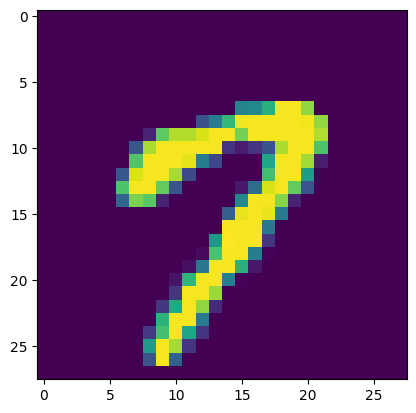

In [20]:
plt.imshow(dataset[0,:,:,0])

# Generacion de Modelos

In [21]:
# create and save a plot of generated images (reversed grayscale)
def save_plot_predict(examples, n):
  # plot images
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(examples[i, :, :, 0], cmap='gray_r')
  plt.show()

In [22]:
# load model
model = load_model('generator_2D_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot_predict(X, 5)

OSError: No file or directory found at generator_2D_model_100.h5